In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import csv
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error
import sympy as sym
from datetime import datetime
from datetime import timedelta
#import seaborn as sns

SOURCE_COVID_19 = "https://pomber.github.io/covid19/timeseries.json"
SOURCE_COUNTRIES_BY_POPULATION = "https://raw.githubusercontent.com/samayo/country-json/master/src/country-by-population.json"
SOURCE_GDP = "https://raw.githubusercontent.com/datasets/gdp/master/data/gdp.csv"
SOURCE_GDP_PER_CAPITA_JSON = "https://pkgstore.datahub.io/world-bank/ny.gdp.pcap.cd/data_json/data/5fa3074284c7b57091aa9bacc502ecb5/data_json.json"
SOURCE_GDP_PER_CAPITA_CSV = "https://datahub.io/world-bank/ny.gdp.pcap.cd/r/data.csv"
def get_data_json(source):
    return requests.get(source).json()

In [6]:
np.warnings.filterwarnings('ignore')

In [7]:
data = requests.get(SOURCE_COVID_19).json()

In [4]:
df = pd.DataFrame.from_dict(data)

In [6]:
def get_average_speed_of_propagation_list(data,status ='confirmed', days = len(data[list(data.keys())[0]]), reverse = False):
    min_days = days
    speed = {}
    for key in data:
        if(len(data[key]) < min_days):
            min_days = len(data[key])
    for key in data:
        speed[key] = round(data[key][min_days - 1][status] / min_days,3)
    speed = {key:value for key, value in sorted(speed.items(), key = lambda item:item[1], reverse = reverse)}
    return speed

In [7]:
def get_average_speed_of_propagation_list_non_zero_days(df,status ='confirmed', reverse = False , count = len(df.columns)):
    speed = {}
    for country_name in df.columns[:count]:
        country = pd.DataFrame.from_dict(data[country_name])
        country = country.loc[country[status] > 0 , ['date',status]].reset_index(drop = True)
        country.index = country.index + 1 # если что, убрать
        if country.empty:
            continue
        speed[country_name] = round(country.iloc[len(country)-1][status] / len(country) , 3)
    speed = {key:value for key, value in sorted(speed.items(), key = lambda item:item[1], reverse = reverse)}
    return speed

In [ ]:
get_average_speed_of_propagation_list_non_zero_days(df,status ='deaths', reverse = False)


In [9]:
def print_speed_stats(data,days = len(data[list(data.keys())[0]]), reverse = False):
    statuses = ['confirmed' , 'deaths' , 'recovered']
    for i in range(len(statuses)):
        print(f"Статистика за {days} дней:{statuses[i]}")
        speed = get_average_speed_of_propagation_list(data,status = statuses[i],days = days,reverse = reverse)
        print(f"Средняя скорость для {statuses[i]} к {days} дню (человек в день):")
        for key in speed:
            print(f"{key}:{speed[key]}")

In [ ]:
# Средняя скорость за все дни( с учётом нулевых)
print_speed_stats(data)

In [11]:
def print_speed_stats_non_zero_days(df, reverse = False , count = len(df.columns)):
    statuses = ['confirmed' , 'deaths' , 'recovered']
    for i in range(len(statuses)):
        print(f"Статистика за значимые( ненулевые) дни:{statuses[i]}")
        speed = get_average_speed_of_propagation_list_non_zero_days(df,statuses[i],reverse , count)
        print(f"Средняя скорость для {statuses[i]} (человек в день):")
        for key in speed:
            print(f"{key}:{speed[key]}")

In [ ]:
# Средняя скорость за все дни( без нулевых значений)
print_speed_stats_non_zero_days(df)

In [13]:
def draw_average_speed_of_propagation_list(data,days = len(data[list(data.keys())[0]]), reverse = False):   
    statuses = ['confirmed' , 'deaths' , 'recovered']
    colors = ['yellow' , 'red' ,'green']
    for i in range(3):
        fig , ax = plt.subplots()
        fig =plt.figure(figsize=(50,40))
        speed = get_average_speed_of_propagation_list(data,status = statuses[i],days = days,reverse = reverse)
        countries = list(speed.keys())
        values = list(speed.values())
        ax.bar(countries,values, color=colors[i])
        ax.set_title(f"{statuses[i]} for {days} days") 
        plt.show()
        

In [14]:
def draw_countries_covid_stats(df, count = len(df.columns)):
    for country_name in df.columns[:count]:
        country = df[country_name]
        x = [index for index in country.index]
        y = [obj['confirmed'] for obj in country]
        y1 = [obj['deaths'] for obj in country] 
        y2 = [obj['recovered'] for obj in country] 
        fig, ax = plt.subplots()
        ax.plot(x,y,label="confirmed")
        ax.plot(x,y1,label="deaths")
        ax.plot(x,y2,label="recovered")
        ax.set_title(country_name)  # Add a title to the axes.
        ax.set_xlabel("days")
        ax.set_ylabel("amount")
        ax.legend()

In [15]:
def create_country_stats_excel_file(df):
    writer = pd.ExcelWriter('covid-19.xlsx', engine='xlsxwriter')
    for country_name in df.columns:
        country = pd.DataFrame.from_dict(data[country_name])
        country_name = "".join([c for c in country_name if c.isalpha()])
        country.to_excel(writer ,sheet_name=country_name, index_label="day")
        #country.to_csv(f"{country_name}.csv" , index_label = "day")

In [16]:
def create_country_stats_excel_file_without_zeroes(df, by='confirmed'):
    writer = pd.ExcelWriter(f"covid-19_{by}.xlsx", engine='xlsxwriter')
    for country_name in df.columns:
        country = pd.DataFrame.from_dict(data[country_name])
        country = country.loc[country[by] > 0 , [by,'date']].reset_index(drop = True)
        country.index = country.index + 1 # если что, убрать
        #print(country)
        country_name = "".join([c for c in country_name if c.isalpha()])
        country.to_excel(writer ,sheet_name=country_name, index_label="day")
        #country.to_csv(f"{country_name}.csv" , index_label = "day")

        

In [17]:
create_country_stats_excel_file_without_zeroes(df)
create_country_stats_excel_file_without_zeroes(df, by='deaths')
create_country_stats_excel_file_without_zeroes(df, by= 'recovered')

In [15]:
# Функции для регрессии
def linear(x,a,b):
    return a*x + b

def exp(x,a,b,c):
    return a*np.exp(b*x)+c

def polynomial_square(x,a,b,c):
    return a*np.square(x) + b*x + c

def polynomial_cube(x,a,b,c,d):
    return a*np.power(x,3) + b*np.square(x) + c*x + d

def log(x,a,b,c):
    return a*np.log(b*x) + c



In [16]:
# Функции для приближения результатов
functions_to_fit = {"linear":linear , "exp":exp , "polynomial_square":polynomial_square ,"polynomial_cube":polynomial_cube, "log":log}

In [78]:
def get_curve_fit_with_params(x,y,method = "r2",functions = functions_to_fit, maxfev = 1000,):
    name = list(functions)[0]
    function =functions[name]
    params = [1,0]
    r_square = 0
    if method == "mse":
        mse = mean_squared_error(y, functions[name](x,*params))
    for key in functions:
        try:
            if key == "exp":
                #opt_params , pcov = curve_fit(functions[key],x,y , p0 = (-1, 0.01, 1),maxfev = 5000) - было
                opt_params , pcov = curve_fit(functions[key],x,y , p0 = (1, 0.01, 1),maxfev = 3000)
            elif key == "sigmoid":
                opt_params , pcov = curve_fit(functions[key],x,y , p0 = [max(y), 1, np.median(x)],maxfev = 10000)
            elif key == "gompertz":
                opt_params , pcov = curve_fit(functions[key],x,y , p0 = [max(y), np.median(x), .1],maxfev = 30000)
            else:
                opt_params , pcov = curve_fit(functions[key],x,y,maxfev = 5000)
        except RuntimeError as e:
            continue
        if method == "r2":   
            r_square_cur = r2_score(y, functions[key](x,*opt_params))
            if r_square_cur > r_square:
                r_square = r_square_cur
                function = functions[key]
                name = key
                params = opt_params         
        else:
            mse_cur = mean_squared_error(y, functions[key](x,*opt_params))
            if mse_cur < mse:
                mse = mse_cur
                function = functions[key]
                name = key
                params = opt_params   
    if method == "mse":
        return (name, function , params, mse)    
    return (name, function , params, r_square)
        
        

In [21]:
def get_country_dependency(country, status, method,functions):
    country_name = country['name']
    data = country['data']
    #print(country_name)
    #print(data)
    if data.empty:
        return None
    x = np.array(list(data.index))
    y = np.array(list(data[status]))
    # 
    if status =="deaths":
        threshold = 4
        if(len(x) < threshold) or (len(y) < threshold) or (len(y) != len(x)):
            return None
    name, func, params, res = get_curve_fit_with_params(x,y,method,functions)
    mark = method 
    res = {"country": country_name , "criteria":status, "dependency":name ,"opt_params":params, method:res }
    #print(res)
    return res


In [22]:
def get_countries_by_status(df , status='confirmed' , count = len(df.columns) ):
    countries =[]
    for country_name in df.columns[:count]:
        country = pd.DataFrame.from_dict(data[country_name])
        country = country.loc[country[status] > 0 , ['date',status]].reset_index(drop = True)
        country.index = country.index + 1 # если что, убрать
        country.index
        countries.append({"name":country_name  ,"data":country})
    return countries

In [23]:
def get_countries_dependencies_by_status(df , status='confirmed' , count = len(df.columns) , method = "r2", functions = functions_to_fit):
    countries = get_countries_by_status(df,status,count)
    dependencies = []
    for country in countries:
        data = get_country_dependency(country,status, method,functions)
        if data is not None:
            dependencies.append(data)
    return dependencies

In [24]:
def print_countries_dependencies_by_status(df , status='confirmed' , count = len(df.columns) , method = "r2",functions = functions_to_fit):
    countries = get_countries_dependencies_by_status(df,status , count , method,functions)
    for country in countries:
        print(f"Страна: {country['country']} , критерий: {country['criteria']}, зависимость: {country['dependency']}")
        print(f"оптимальные параметры:" , end = " ")
        for param in country['opt_params']:
            print(param, end = ', ')
        print()
        print(f"{list(country.keys())[-1]}: {country[list(country.keys())[-1]]}")

In [ ]:
#Функции зависимости стран по количеству заражённых умерших и выздоровевших
# methods = ['r2' , 'mse']
#statuses ['confirmed' , 'deaths', 'recovered']
# Лучшие результаты при кубическом трёхчлене, при его отсутствии - при квадратном трёхчлене
print_countries_dependencies_by_status(df , status='confirmed' , count = len(df.columns) , method = "r2")

In [8]:
pop_data = requests.get(SOURCE_COUNTRIES_BY_POPULATION).json()

In [9]:
data["United States"] = data.pop("US")
df = df.rename(columns={"US": "United States"})

In [10]:
def get_procent_to_population(data,df,pop_data, count = len(df.columns)):
    result = []
    for country_name in df.columns[:count]: 
        country = pd.DataFrame.from_dict(data[country_name])    
        for state in pop_data:
            if state['country'] == country_name:
                population = state['population']
                break
        population = int(state['population'])
        confirmed = int(country.iloc[len(country)-1]['confirmed']) / population * 100
        dead = int(country.iloc[len(country)-1]['deaths']) / population * 100
        result.append({"country":country_name ,"population":population , "conf_to_pop":confirmed, "dead_to_pop":dead})
    return result

In [11]:
def print_procent_to_population(data,df,pop_data, count = len(df.columns)):
    countries = get_procent_to_population(data,df,pop_data,count) 
    for country in countries:
        print(f"Страна: {country['country']} , население: {country['population']} , процент заразившихся: {country['conf_to_pop']} , процент умерших: {country['dead_to_pop']}")
    

In [ ]:
# Кол-во заразившихся и умерших в процентах от всего населения
print_procent_to_population(data,df,pop_data)

In [13]:
gdp_data_response = requests.get(SOURCE_GDP)
csv_path = "gdp.csv"

In [12]:
per_capita_data = requests.get(SOURCE_GDP_PER_CAPITA_JSON).json()

In [9]:
def set_csv_file(gdp_data_response,csv_path):
    csv_gdp_file = open(csv_path,'wb')
    csv_gdp_file.write(gdp_data_response.content)
    csv_gdp_file.close()
    

In [34]:
set_csv_file(csv_path)

In [8]:
def change(country):
    if country == "Bahamas, The":
        return "Bahamas"
    if country =="Brunei Darussalam":
        return "Brunei"
    elif country == "Congo, Dem. Rep.":
        return "Congo (Kinshasa)"
    elif country == "Congo, Rep.":
        return "Congo (Brazzaville)"
    elif country =="Egypt, Arab Rep.":
        return "Egypt"
    elif country == "Korea, Rep.":
        return "Korea, South"
    elif country == "Kyrgyz Republic":
        return "Kyrgyzstan"
    elif country =="Russian Federation":
        return "Russia"
    elif country == "St. Vincent and the Grenadines":
        return "Saint Vincent and the Grenadines"
    elif country == "Venezuela, RB":
        return "Venezuela"
    elif country == "US":
        return "United States"
    elif country == "Yemen, Rep.":
        return "Yemen"
    return country
    

In [36]:

def get_countries_gdp_csv(csv_path):
    countries = []
    length = 0
    with open(csv_path,"r") as csv_file:
        for line in csv_file:
            length +=1
    count = 0
    with open(csv_path,"r") as csv_file:
        line = csv_file.readline().split(",")
        while (line[0] != "Afghanistan"):
            line = csv_file.readline().split(",")
        while(count< length):
            line = csv_file.readline().split(",")
            if len(line) < 4:
                break
            if line[2] == "2016":
                #countries.append({"country":change((line[0])) , "gdp":int(line[3])})
                countries.append({"country":change((line[0])) , "gdp":int(round(float(line[3])))}) # было
            count+=1
    return countries

In [37]:
def get_countries_per_capita(per_capita_data):
    countries = []
    length = len(per_capita_data)
    count = 0
    _iter = iter(per_capita_data)
    key = next(_iter)

    while key['Country Name']!= 'Afghanistan':
        key = next(_iter)
        count+=1
    while(count + 1 < length):
        key = next(_iter)
        count+=1
        if(int(key['Year']) == 2016):
            countries.append({"country":change((key['Country Name'])) , "per_capita":int(key['Value'])})
    return countries

In [ ]:
get_countries_per_capita(per_capita_data)

In [39]:
def get_country_list_by_param(percentage_list,param_list,param = "gdp", divider = 10**9):
    _list = []
    for country in percentage_list:
        for state in param_list:
            if country['country'] == state['country']:
                country[param] = float(state[param]) / divider
                _list.append(country)
                break
    return _list

In [40]:
# ВВП в миллиардах долларов
# Среднедушевой доход в тысячах долларов
divider_gdp = 1000000000
divider_per_capita = 1000
gdp_csv_list = get_countries_gdp_csv(csv_path)
per_capita_list = get_countries_per_capita(per_capita_data)
states_percentage = get_procent_to_population(data,df,pop_data) 
countries_with_gdp = get_country_list_by_param(states_percentage,gdp_csv_list,divider = divider_gdp)
countries_with_gdp_and_capita = get_country_list_by_param(countries_with_gdp,per_capita_list, param="per_capita", divider = divider_per_capita)


In [41]:
#statuses('conf_to_pop' , "dead_to_pop")

In [42]:
def get_data_by_param_and_status(countries, param = "gdp", status='conf_to_pop'):
    _sorted = sorted(countries, key=lambda k: k[param]) 
    _x = []
    _y = []
    for country in _sorted:
        _x.append(country[param])
        _y.append(country[status])
    #return np.array(_x) , np.array(_x)
    return _x , _y

In [43]:
def get_dependency_by_param_and_status(countries, param="gdp", status='conf_to_pop', method = "r2", functions = functions_to_fit):
    x,y = get_data_by_param_and_status(countries,param,status)
    name, func , params , res = get_curve_fit_with_params(np.array(x),np.array(y),method,functions)
    return {"criteria":status,"param":param, "dependency":name ,"opt_params":params, method:res }

In [44]:
def print_dependency_by_param_and_status(countries, param = "gdp", status='conf_to_pop', method = "r2",functions = functions_to_fit):
    res = get_dependency_by_param_and_status(countries, param, status, method)
    _param = "ВВП" if res['param']=="gdp" else "Среднешушевой доход"
    _param_con = "ВВП" if res['param']=="gdp" else "Среднешушевого дохода"
    print(f"Кривая для {_param_con}:")
    criteria = f"Процент заражённых/{_param}" if res['criteria'] =="conf_to_pop" else f"Процент умерших/{_param}"
    print(f"Критерий: {criteria}, зависимость: {res['dependency']}")
    print("Оптимальные параметры:" , end = " ")
    for param in res['opt_params']:
        print(param, end = ", ")
    print()
    print(f"{list(res.keys())[-1]}: {res[list(res.keys())[-1]]}")

In [45]:
#statuses('conf_to_pop' , "dead_to_pop")
#params('gdp','per_capita')
#Функции зависимости стран по процентному количеству заражённых/умерших в зависимости от увеличения ВВП/Среднедушевого дохода
#Как и при динамике количества, оптимальные параметры выдаёт кубическая функция, хоть и с достаточно малыми коэффициентами
print_dependency_by_param_and_status(countries_with_gdp_and_capita,param="gdp", status='conf_to_pop', method = "r2", functions = functions_to_fit)

Кривая для ВВП:
Критерий: Процент заражённых/ВВП, зависимость: polynomial_cube
Оптимальные параметры: 1.2998486237765217e-12, -3.281122328546334e-08, 0.00018267613568219575, 0.09697079604888227, 
r2: 0.0617116208061157


In [34]:
import chart_studio.plotly.plotly as py #For World Map
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering
import seaborn as sns
import os                     # For os related operations
import sys                    # For data size

In [47]:
def get_countries_with_gdp_and_capita(csv_path,per_capita_data,divider_gdp = 1,divider_per_capita = 1):
    gdp_csv_list = get_countries_gdp_csv(csv_path)
    per_capita_list = get_countries_per_capita(per_capita_data)
    states_percentage = get_procent_to_population(data,df,pop_data) 
    with_gdp = get_country_list_by_param(states_percentage,gdp_csv_list,divider = divider_gdp)
    with_gdp_and_capita = get_country_list_by_param(with_gdp,per_capita_list, param="per_capita", divider = divider_per_capita)
    return with_gdp_and_capita

In [48]:
# ВВП в миллиардах долларов
# Среднедушевой доход в тысячах долларов
divider_gdp = 1000000000
divider_per_capita = 1000
gdp_csv_list = get_countries_gdp_csv(csv_path)
per_capita_list = get_countries_per_capita(per_capita_data)
states_percentage = get_procent_to_population(data,df,pop_data) 
countries_with_gdp = get_country_list_by_param(states_percentage,gdp_csv_list,divider = divider_gdp)
countries_with_gdp_and_capita = get_country_list_by_param(countries_with_gdp,per_capita_list, param="per_capita", divider = divider_per_capita)

In [49]:
df_cl = pd.DataFrame(countries_with_gdp_and_capita)

In [ ]:
df_cl_1 = df_cl[['gdp','per_capita','population','conf_to_pop', 'dead_to_pop']]
cor = df_cl_1.corr()
sns.set()
sns.heatmap(cor, square = True) 
plt.title("Корреляция между параметрами:")
plt.show()

In [ ]:
data = dict(type = 'choropleth', 
           locations = df_cl['country'],
           locationmode = 'country names',
           z = df_cl['conf_to_pop'], 
           text = df_cl['country'],
           colorbar = {'title':'Заражённые'})
layout = dict(title = 'Заражённые по отношению к населению(%)', 
             geo = dict(showframe = False, 
                       projection = {'type': 'mercator'}))
choromap3 = go.Figure(data = [data], layout=layout)
iplot(choromap3)

In [ ]:
data = dict(type = 'choropleth', 
           locations = df_cl['country'],
           locationmode = 'country names',
           z = df_cl['dead_to_pop'], 
           text = df_cl['country'],
           colorbar = {'title':'Умершие'})
layout = dict(title = 'Умершие по отношению к населению(%)', 
             geo = dict(showframe = False, 
                       projection = {'type': 'mercator'}))
choromap3 = go.Figure(data = [data], layout=layout)
iplot(choromap3)

In [ ]:
data = dict(type = 'choropleth', 
           locations = df_cl['country'],
           locationmode = 'country names',
           z = df_cl['gdp'], 
           text = df_cl['country'],
           colorbar = {'title':'ВВП(млрд. долларов)'})
layout = dict(title = 'ВВП в млрд. долларов США', 
             geo = dict(showframe = False, 
                       projection = {'type': 'mercator'}))
choromap3 = go.Figure(data = [data], layout=layout)
iplot(choromap3)

In [ ]:
data = dict(type = 'choropleth', 
           locations = df_cl['country'],
           locationmode = 'country names',
           z = df_cl['gdp'], 
           text = df_cl['country'],
           colorbar = {'title':'Среднедушевой доход(тыс.долларов)'})
layout = dict(title = 'Среднедушевой доход в тыс. долларов США', 
             geo = dict(showframe = False, 
                       projection = {'type': 'mercator'}))
choromap3 = go.Figure(data = [data], layout=layout)
iplot(choromap3)

In [43]:
# Кластеризация методом k-средних
def do_kmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)



In [56]:
df_cl = pd.DataFrame(countries_with_gdp_and_capita)
df_cl_1 = df_cl[['gdp','per_capita','population','conf_to_pop', 'dead_to_pop']]

In [57]:
scaler = StandardScaler()
s = scaler.fit_transform(df_cl_1)

In [58]:
clust_labels, cent = do_kmeans(df_cl_1, 2)
kmeans = pd.DataFrame(clust_labels)
df_cl_1.insert((df_cl_1.shape[1]),'kmeans',kmeans)

In [59]:
# Кластеризация с 2 параметрами
def plot_clusterization(df_cl_1,method, param_1 = "gdp" , param_2 = "conf_to_pop", title=""):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    scatter = ax.scatter(df_cl_1[param_1],df_cl_1[param_2],
                         c=method[0],s=50)
    ax.set_title(title)
    if param_1 == "gdp":
        xlabel = "ВВП (млрд.долларов)"
    elif param_1 == "per_capita":
        xlabel = "Среднедушевой доход (тыс.долларов)"
    elif param_1 == "conf_to_pop":
        xlabel = "Заразившиеся в (%) от населения"
    elif param_1 == "dead_to_pop":
        xlabel = "Умершие в (%) от населения"  
    if param_2 == "gdp":
        ylabel = "ВВП (млрд.долларов)"
    elif param_2 == "per_capita":
        ylabel = "Среднедушевой доход (тыс.долларов)"
    elif param_2 == "conf_to_pop":
        ylabel = "Заразившиеся в (%) от населения"
    elif param_2 == "dead_to_pop":
        ylabel = "Умершие в (%) от населения" 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.colorbar(scatter)

In [ ]:
plot_clusterization(df_cl_1,kmeans, "per_capita" , "dead_to_pop", "Кластеризация методом k-средних")    

In [ ]:
#Карта кластеризации( k-средних)
df_cl_1.insert(0,'country',df_cl.iloc[:,0])
df_cl_1.iloc[:,[0,1,2,3,4,5]]
data = [dict(type='choropleth',
             locations = df_cl_1['country'],
             locationmode = 'country names',
             z = df_cl_1['kmeans'],
             text = df_cl_1['country'],
             colorbar = {'title':'Cluster Group'})]
layout = dict(title='Clustering of Countries based on K-Means',
              geo=dict(showframe = False,
                       projection = {'type':'mercator'}))
map1 = go.Figure(data = data, layout=layout)
iplot(map1)

In [62]:
def do_agglomerative(X, nclust=2):
    model = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage = 'ward')
    clust_labels1 = model.fit_predict(X)
    return (clust_labels1)

In [63]:
df_cl = pd.DataFrame(countries_with_gdp_and_capita)
df_cl_1 = df_cl[['gdp','per_capita','population','conf_to_pop', 'dead_to_pop']]

In [64]:
scaler = StandardScaler()
s= scaler.fit_transform(df_cl_1)

In [65]:
clust_labels1 = do_agglomerative(df_cl_1, 2)
agglomerative = pd.DataFrame(clust_labels1)
df_cl_1.insert((df_cl_1.shape[1]),'agglomerative',agglomerative)

In [ ]:
#Агломеративная_кластеризация
plot_clusterization(df_cl_1,agglomerative, "per_capita" , "dead_to_pop", "Агломеративная кластеризация")

In [ ]:
#Карта кластеризации( агломеративная)
df_cl_1.insert(0,'country',df_cl.iloc[:,0])
df_cl_1.iloc[:,[0,1,2,3,4,5]]
data = [dict(type='choropleth',
             locations = df_cl_1['country'],
             locationmode = 'country names',
             z = df_cl_1['agglomerative'],
             text = df_cl_1['country'],
             colorbar = {'title':'Cluster Group'})]
layout = dict(title='Grouping of Countries based on Affinity Clustering',
              geo=dict(showframe = False, projection = {'type':'mercator'}))
map3 = dict(data=data, layout=layout)
iplot(map3)

In [10]:
data = requests.get(SOURCE_COVID_19).json()
count=1
SOME_VALUE = 1000

In [11]:
functions = {"exp":exp}
def check_exp(data, status='confirmed',count = len(data), method="r2", accuracy = 0.99):
    i = 0
    for name in data.keys():
        if i==count:
            break
        i+=1
        country = pd.DataFrame.from_dict(data[name])
        country = country.loc[country[status] > 0 , ['date',status]].reset_index(drop = True)
        if country.empty:
            continue
        country.index = country.index + 1# если что, убрать
        x = [x +1 for x in range(len(country))]
        y = list(country[status])
        x = np.array(x)
        colors = {'confirmed':'orange' , 'deaths':'r', 'recovered':'g'}
        opt_params , pcov = curve_fit(exp,x,y , p0 = (1, 0.01, 1),maxfev = 30000)
        estimated = exp(x,*opt_params)
        estimated_color = "blue"
        if method == "r2":   
            res = r2_score(y,estimated)
        else:
            res = mean_squared_error(y,estimated)
        #_name, func, opt_params, res = get_curve_fit_with_params(np.array(x),np.array(y),method,functions=functions)
        some = {"country": name, method:res }
        if method=="r2":    
            if res - accuracy > 0:
                print(some) 
                plt.plot(x,y,"--",color=colors[status], linewidth=2.0, label=status)
                plt.plot(x,estimated,color=estimated_color, linewidth=2.0, label="params: {:.3f}, {:.3f}, {:.3f}".format(*opt_params))
                plt.title(name)
                plt.xlabel("Days")
                plt.ylabel("Total count")
                plt.legend()
                plt.show()
        else:
            if res < SOME_VALUE:
                pass
                #for mse
        


In [ ]:
check_exp(data,'confirmed')

In [ ]:
# Предсказание динамики по странам и миру через сигмоиды

In [24]:
def sigmoid(x,a,b,c):
    return a / (1.0 + np.exp(-b * (x - c))) # можно варьировать

In [25]:
def gompertz(x, a, b, c):
    return a * np.exp(-b * np.exp(-c * x))

In [26]:
model_functions ={"sigmoid":sigmoid , "gompertz":gompertz}

In [82]:
functions_to_fit = {"linear":linear , "exp":exp , "polynomial_square":polynomial_square ,"polynomial_cube":polynomial_cube,"sigmoid":sigmoid , "gompertz":gompertz, "log":log}

In [11]:
def forecast_countries(data, status = 'confirmed', model_function = "sigmoid", period = 30, count = len(data)):
    i = 0
    for name in data.keys():
        if i==count:
            break
        i+=1
        country = pd.DataFrame.from_dict(data[name])
        country = country.loc[country[status] > 0 , ['date',status]].reset_index(drop = True)
        if country.empty:
            continue
        country.index = country.index + 1# если что, убрать
        x = [x + 1 for x in range(len(country))]
        y = list(country[status])
        x = np.array(x)
        colors = {'confirmed':'orange' , 'deaths':'r', 'recovered':'g'}
        #как выбирать p0? # Здесь для сигмоиды
        if model_function == "sigmoid":
            p = [max(y), 1, np.median(x)]
        if model_function == "gompertz":
            p = [max(y), np.median(x), .1]
        else:
            p = [1,0,1] #?
        opt_params , pcov = curve_fit(model_functions[model_function],x,y , p0=p,maxfev = 30000)
        x_modeled = np.array([x + 1 for x in range(len(x) + period)])
        estimated = model_functions[model_function](x_modeled,*opt_params)
        estimated_color = "blue" 
        plt.plot(x,y,"--",color=colors[status], linewidth=2.5, label=status)
        plt.plot(x_modeled,estimated,"--",color=estimated_color, linewidth=2.0, label="predicted")
        plt.title(name)
        plt.xlabel("Days")
        plt.ylabel("Total count")
        plt.legend()
        plt.show()
       
        
    

In [95]:
def forecast_countries_auto(data, status = 'confirmed', method = "r2", functions = model_functions, period = 30, count = len(data)):
    countries = []
    i = 0
    for name in data.keys():
        if i==count:
            break
        i+=1
        country = pd.DataFrame.from_dict(data[name])
        country = country.loc[country[status] > 0 , ['date',status]].reset_index(drop = True)
        if country.empty:
            continue
        country.index = country.index + 1# если что, убрать
        x = [x + 1 for x in range(len(country))]
        y = list(country[status])
        x = np.array(x)
        colors = {'confirmed':'orange' , 'deaths':'r', 'recovered':'g'}
        d_name, func, opt_params, res = get_curve_fit_with_params(x,y,method,functions)
        mark = method 
        res = {"country": name , "criteria":status, "dependency":d_name ,"opt_params":opt_params, method:res }
        countries.append(res)
        #как выбирать p0? # Здесь для сигмоиды
        #opt_params , pcov = curve_fit(model_functions[model_function],x,y , p0=p,maxfev = 30000)
        x_modeled = np.array([x + 1 for x in range(len(x) + period)])
        estimated = functions[d_name](x_modeled,*opt_params)
        estimated_color = "blue" 
        plt.plot(x,y,"--",color=colors[status], linewidth=2.5, label=status)
        plt.plot(x_modeled,estimated,"--",color=estimated_color, linewidth=2.0, label=f"predicted({d_name})")
        plt.title(name)
        plt.xlabel("Days")
        plt.ylabel("Total count")
        plt.legend()
        #plt.figure(figsize=(20,16))
        plt.show()
    return countries

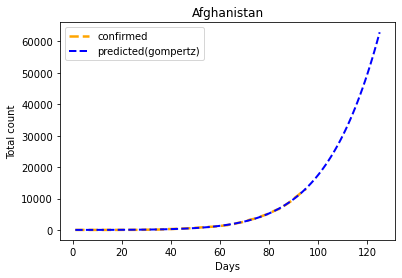

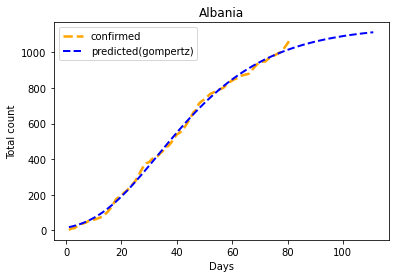

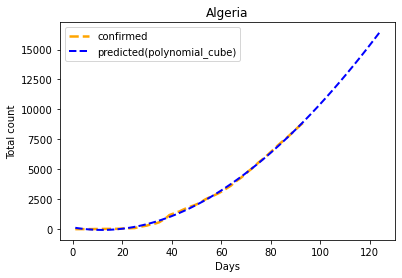

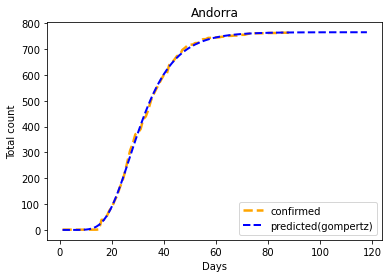

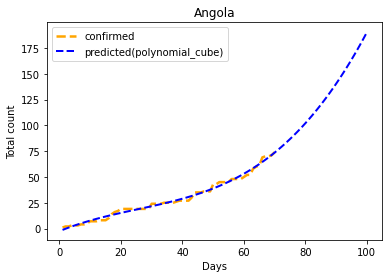

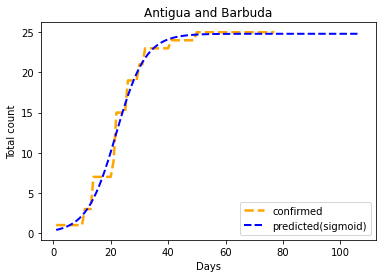

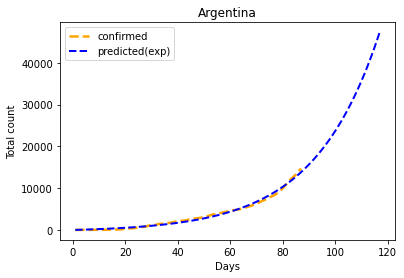

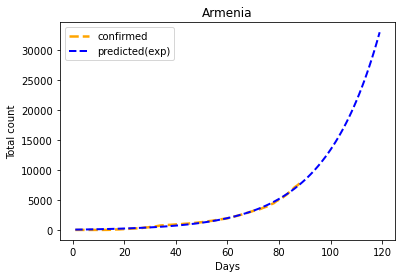

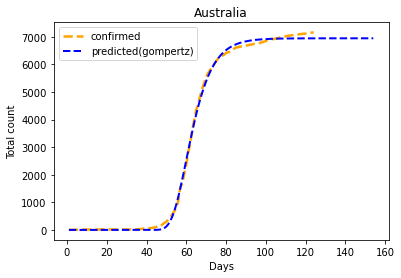

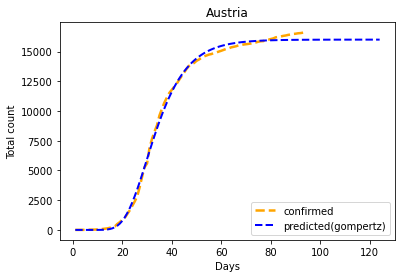

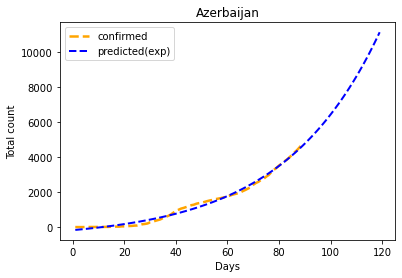

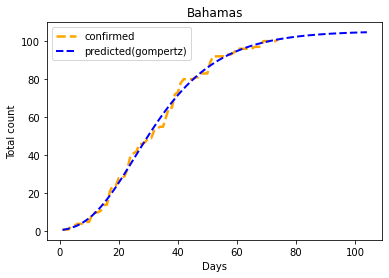

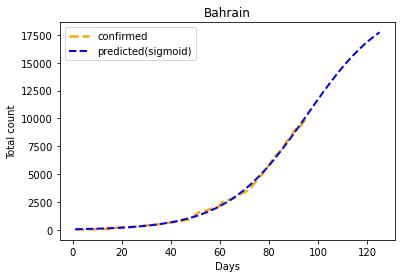

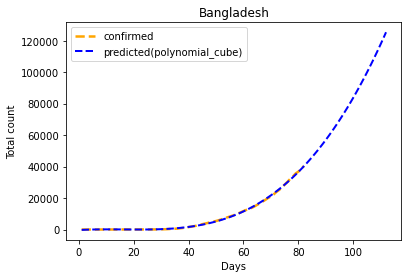

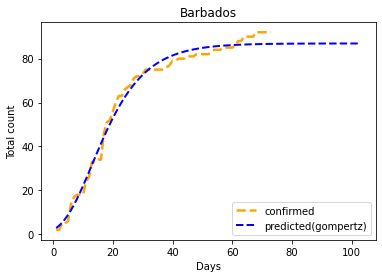

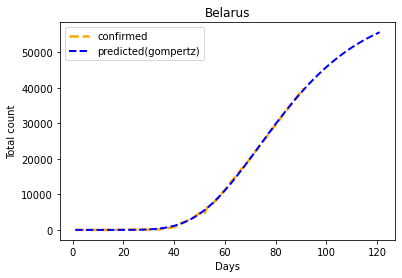

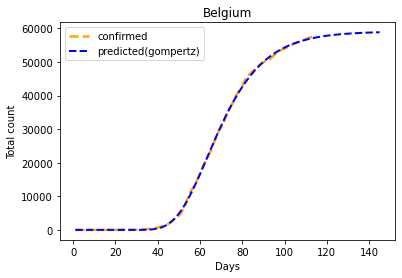

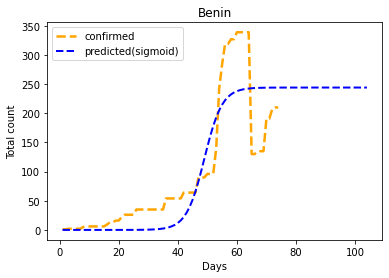

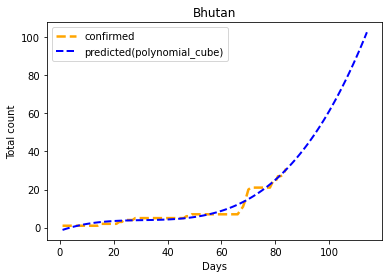

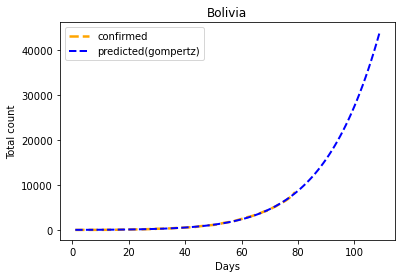

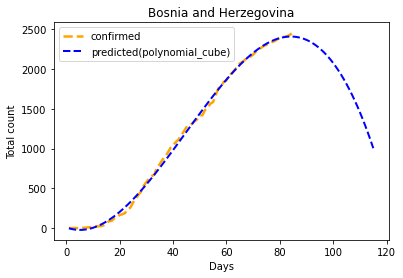

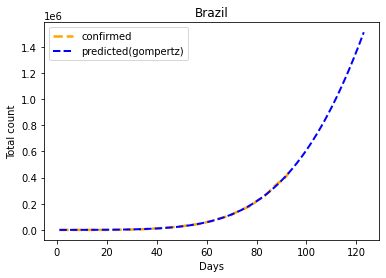

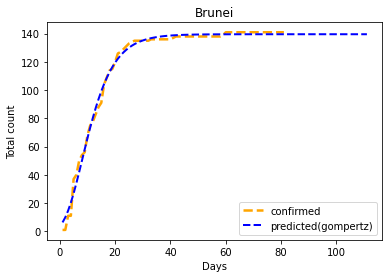

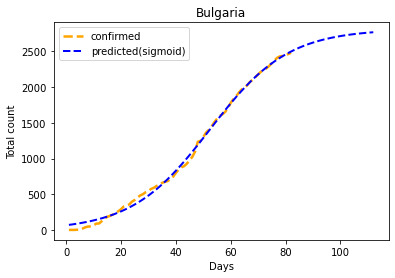

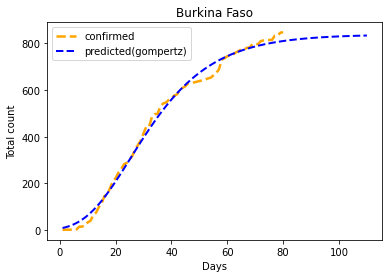

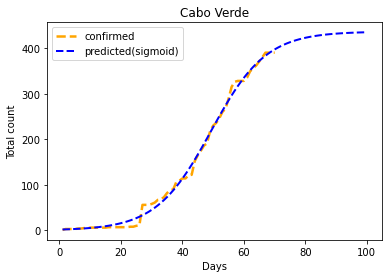

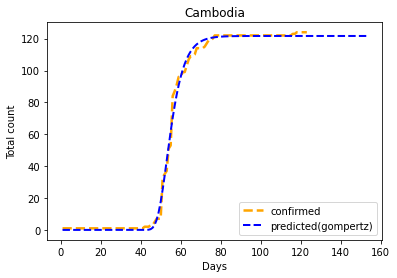

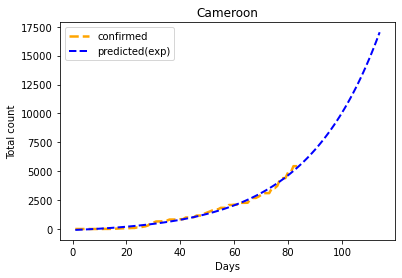

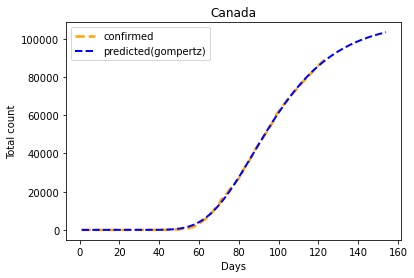

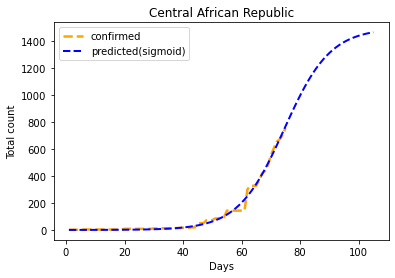

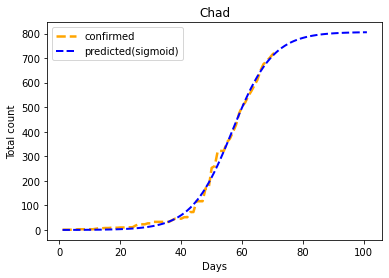

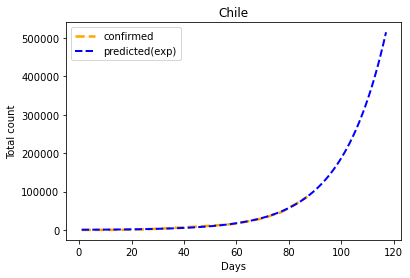

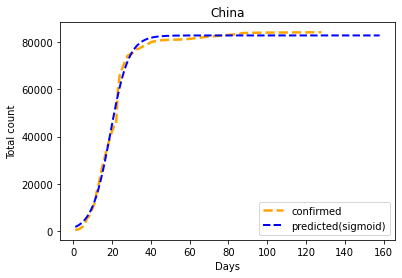

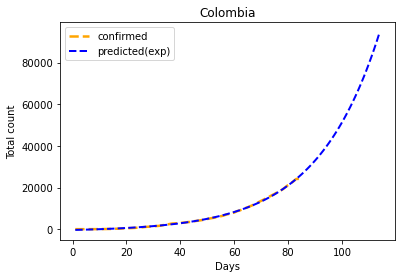

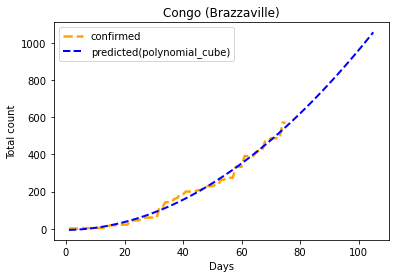

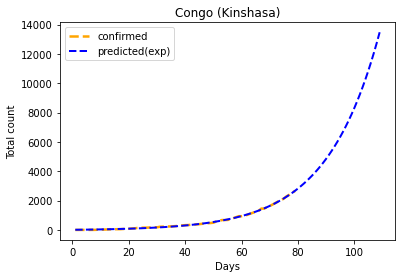

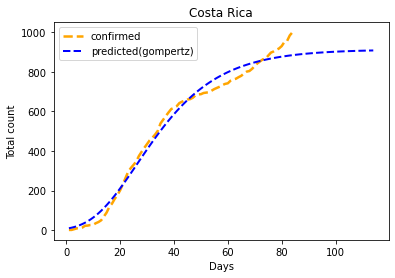

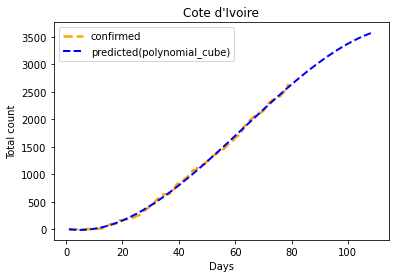

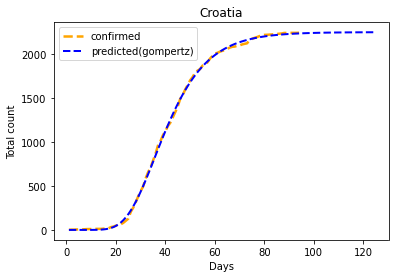

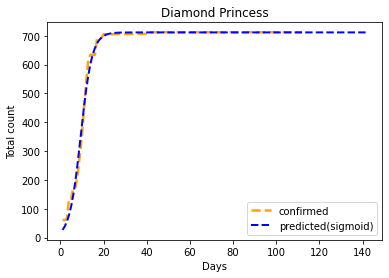

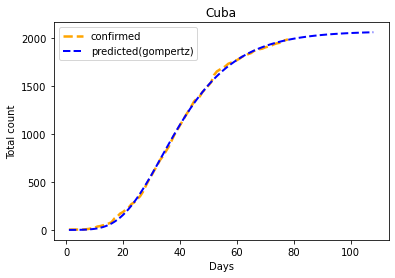

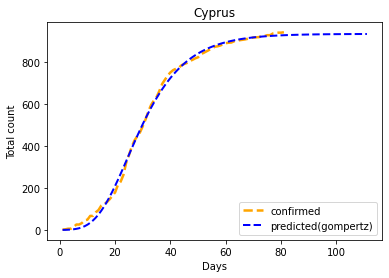

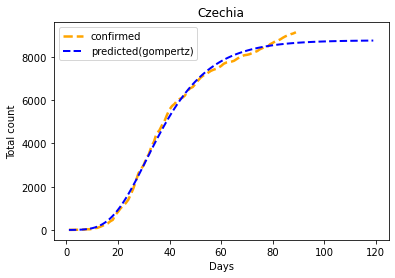

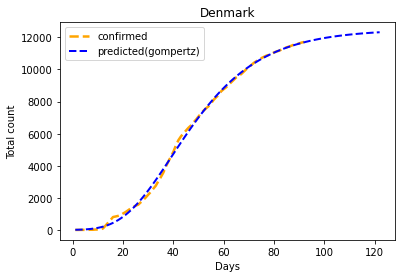

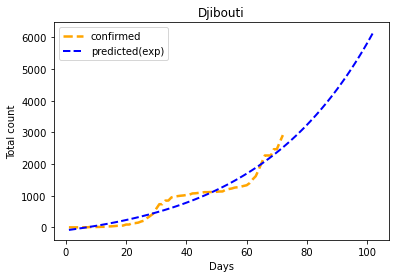

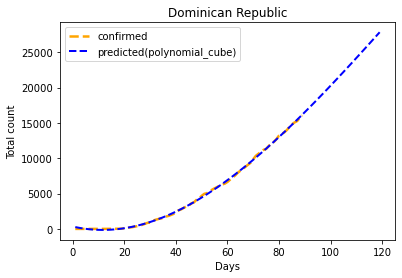

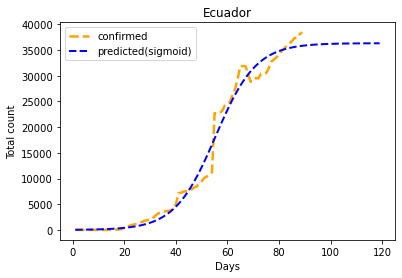

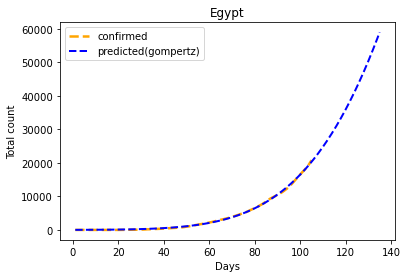

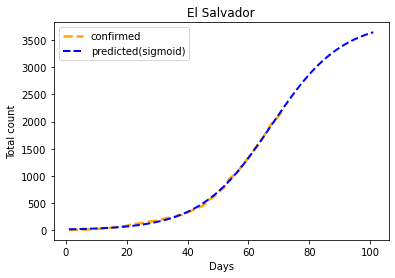

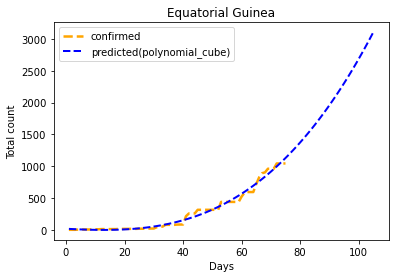

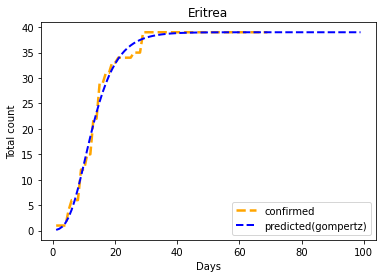

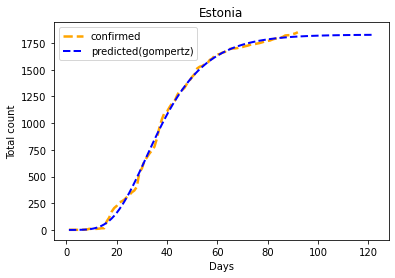

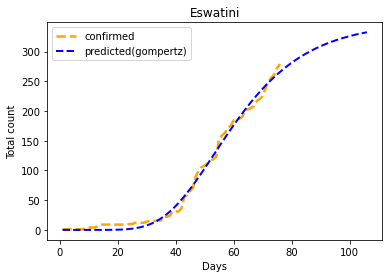

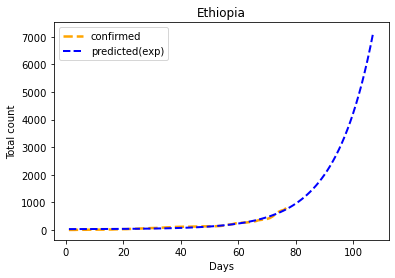

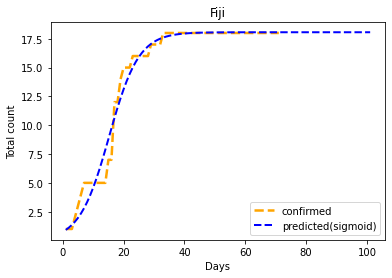

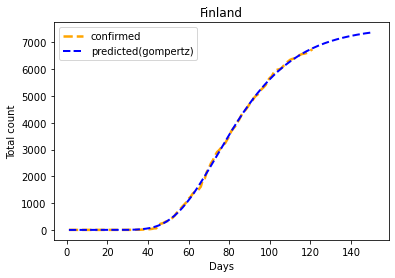

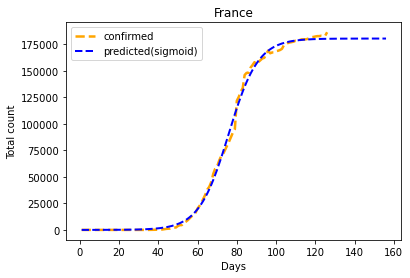

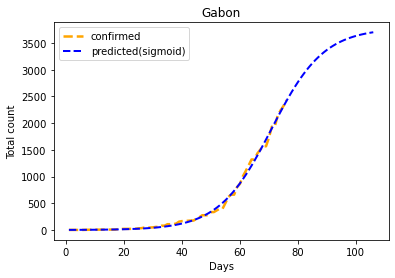

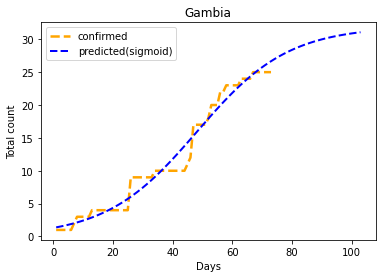

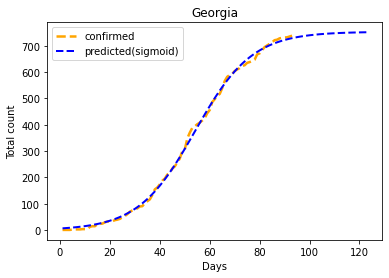

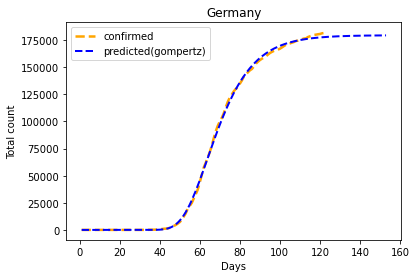

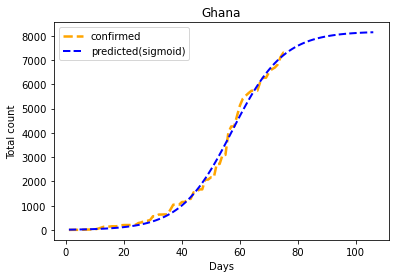

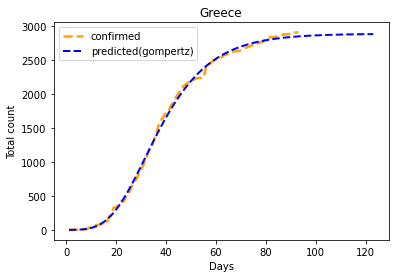

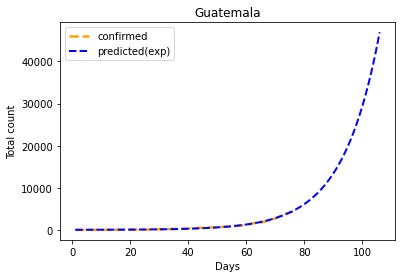

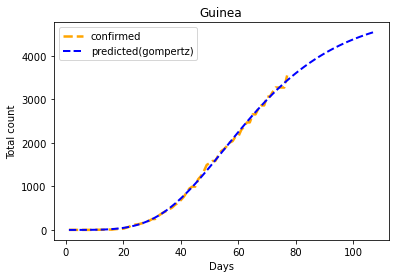

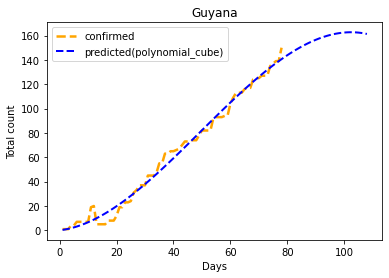

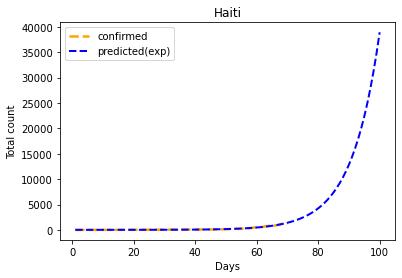

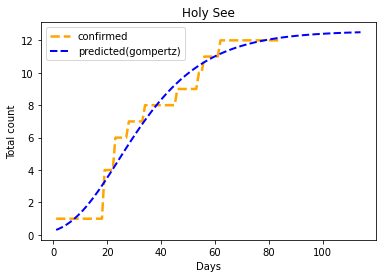

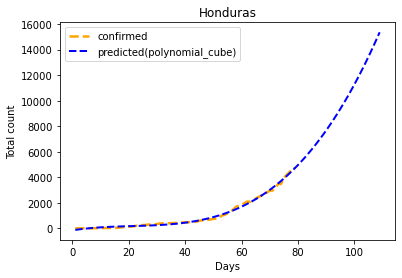

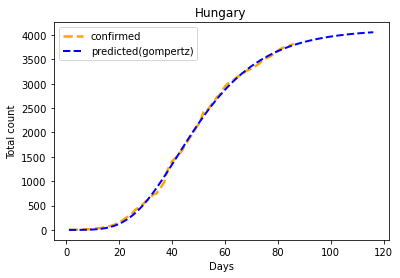

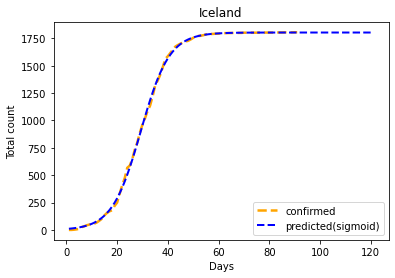

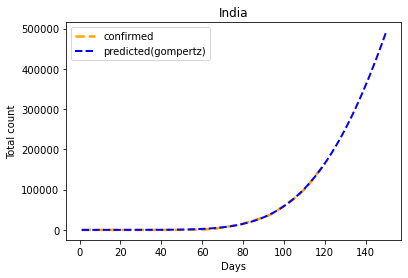

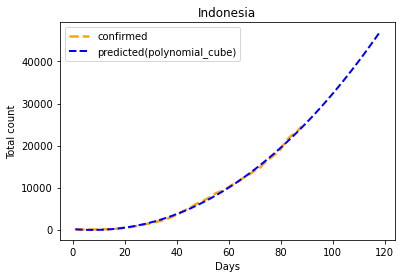

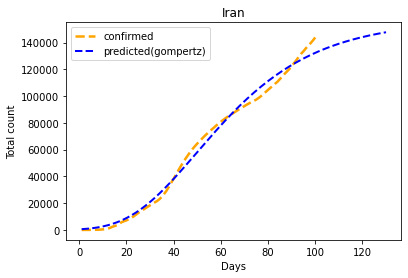

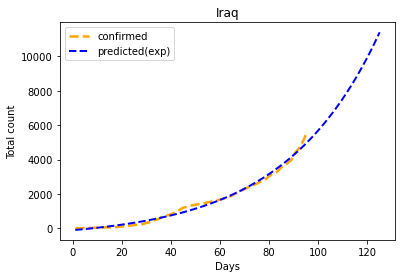

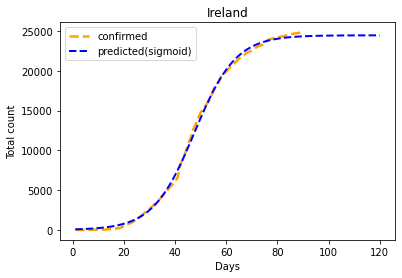

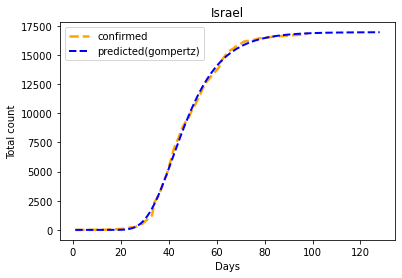

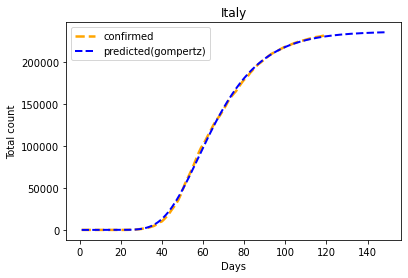

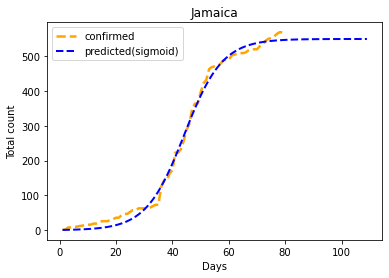

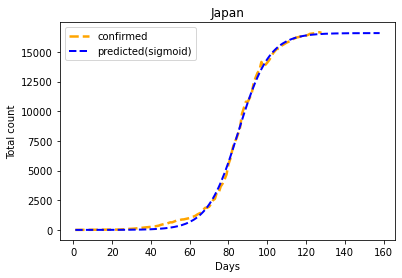

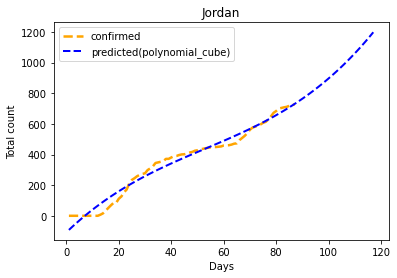

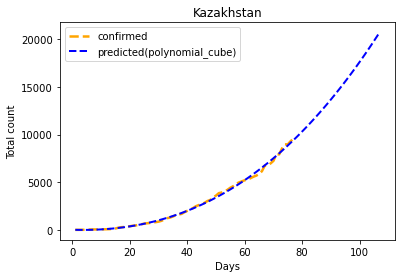

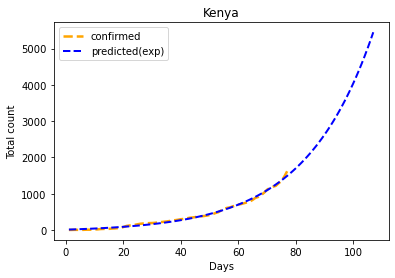

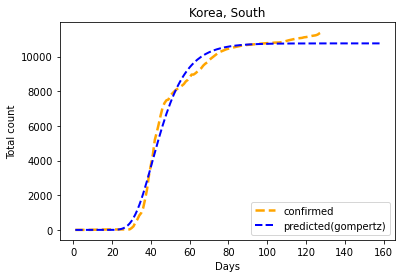

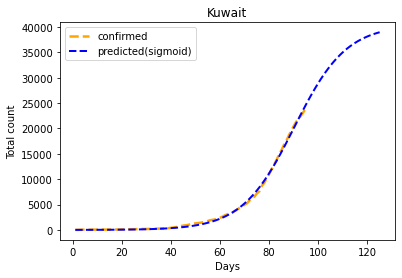

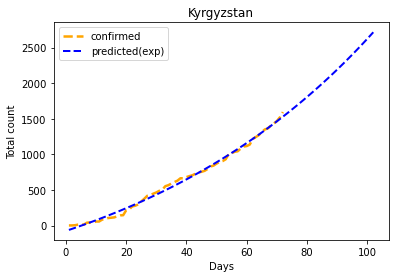

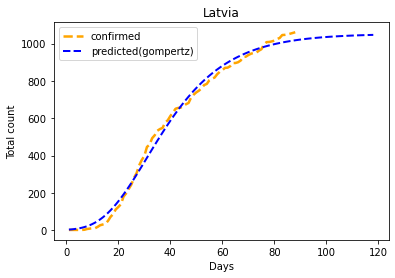

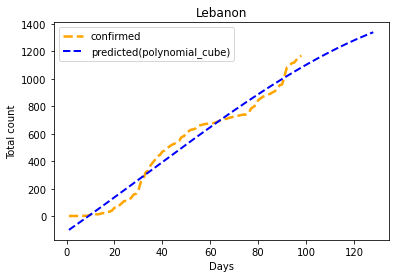

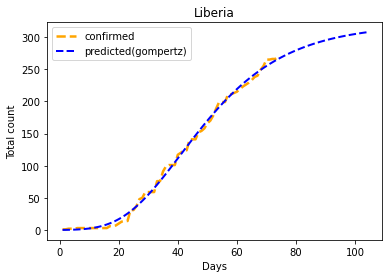

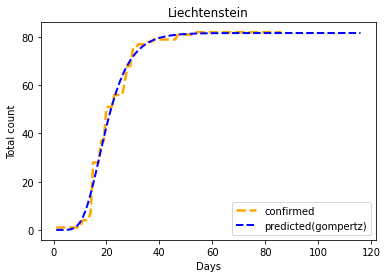

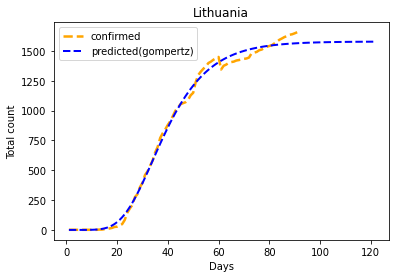

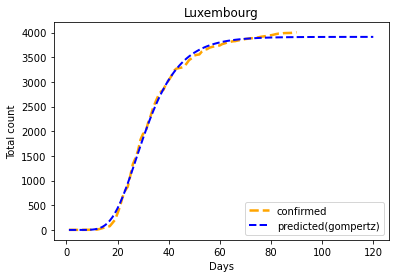

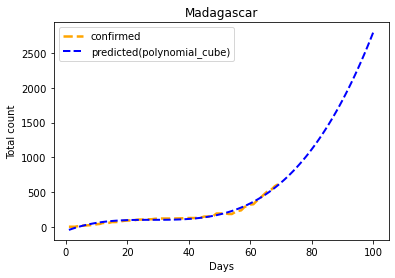

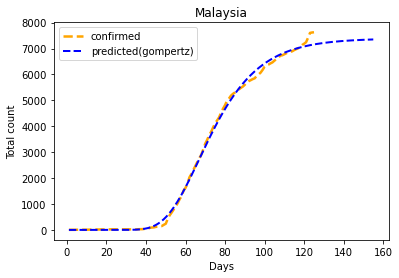

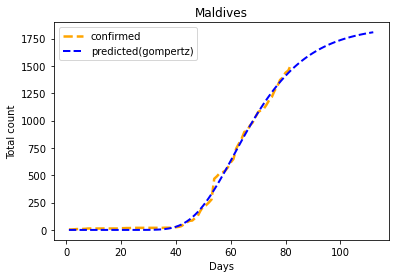

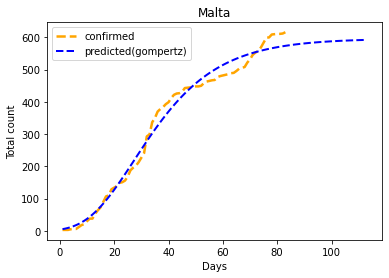

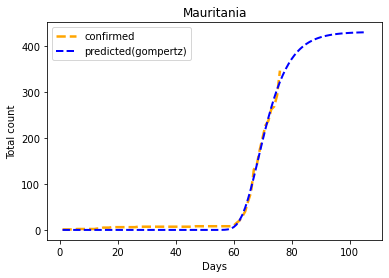

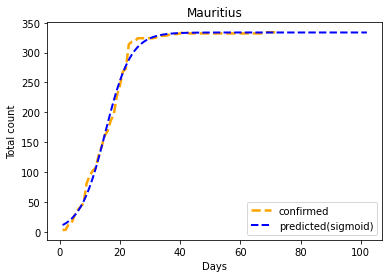

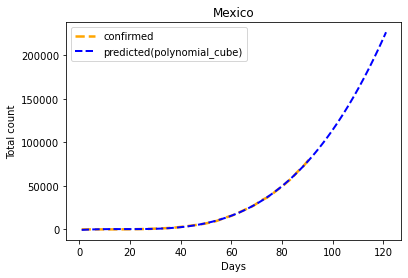

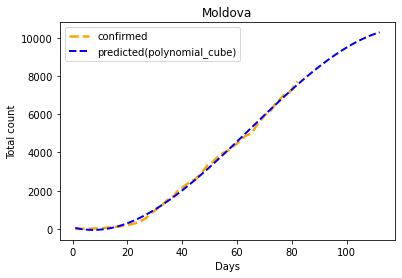

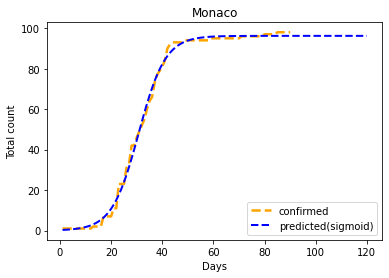

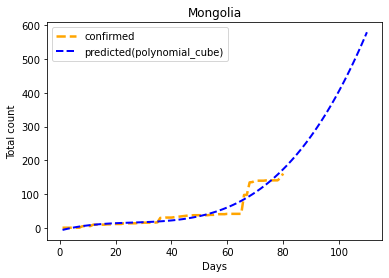

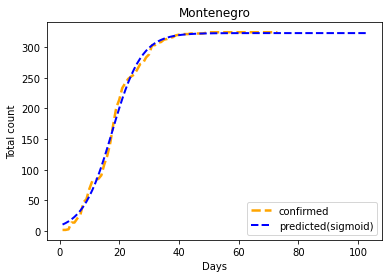

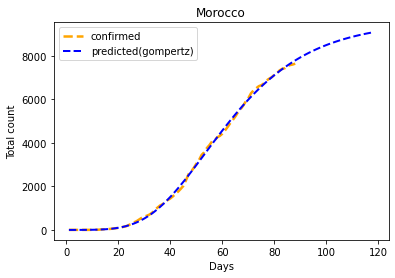

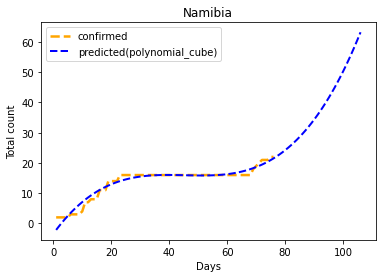

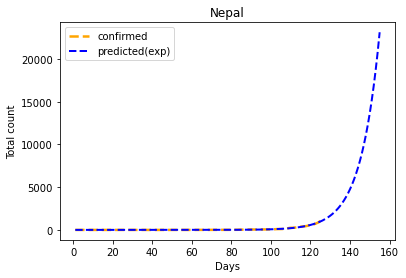

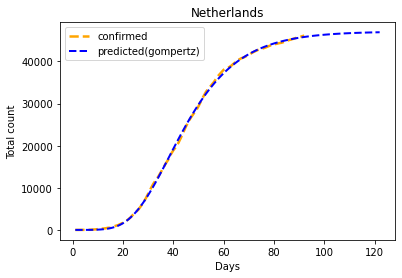

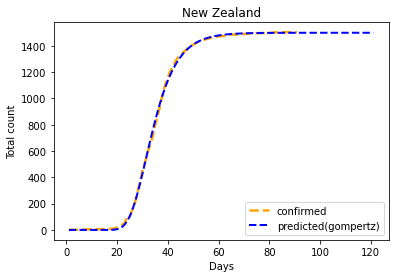

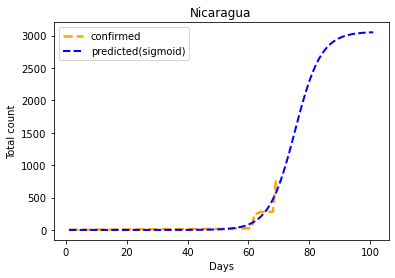

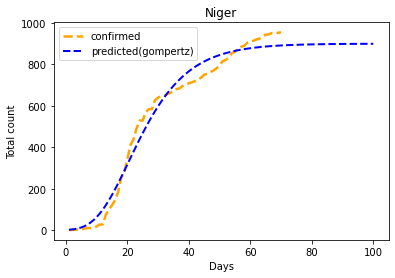

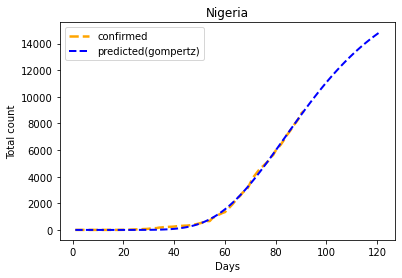

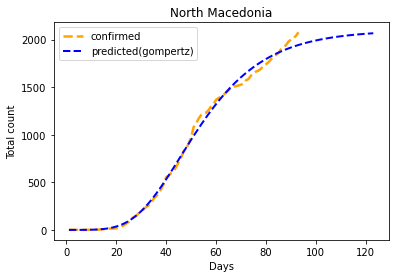

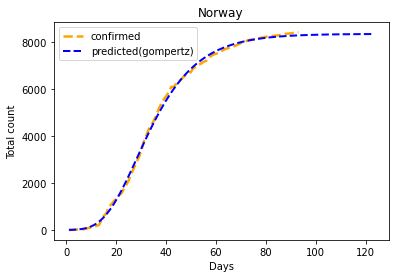

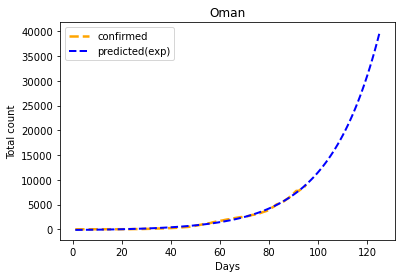

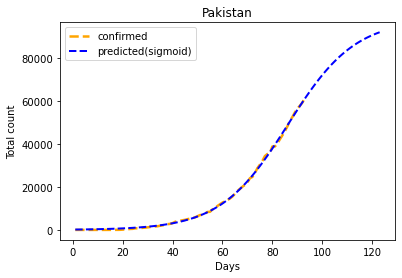

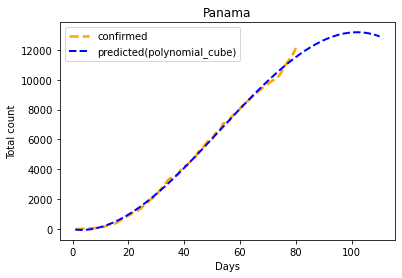

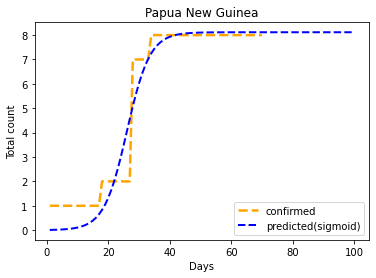

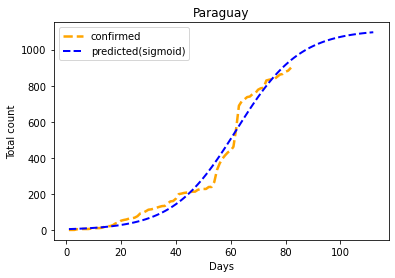

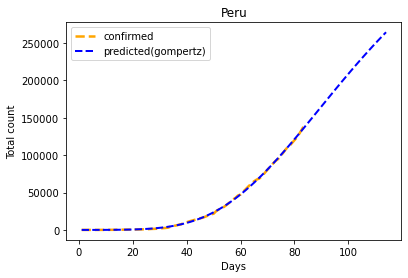

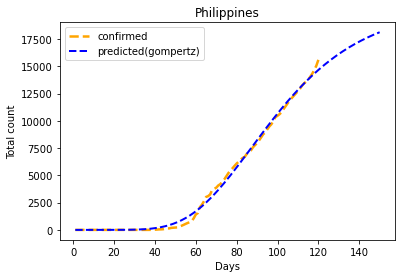

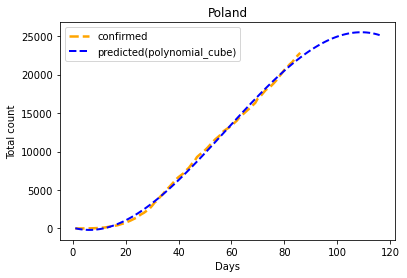

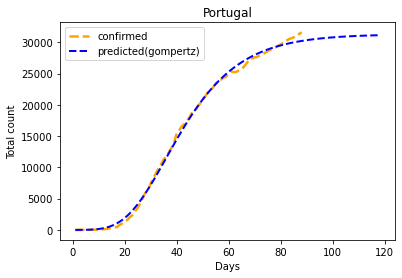

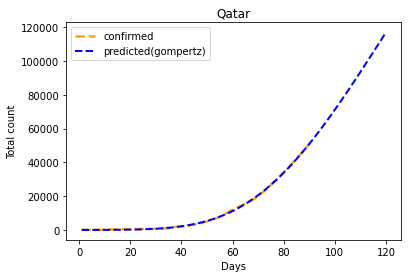

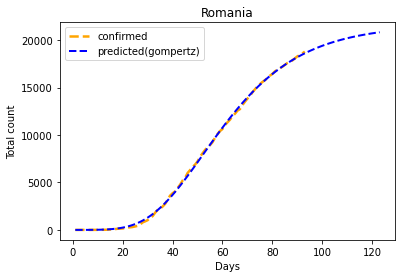

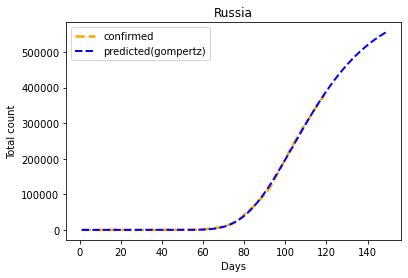

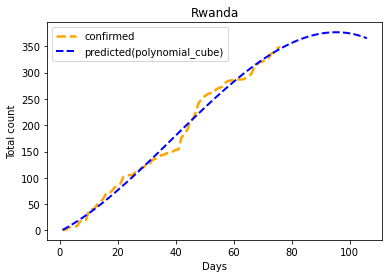

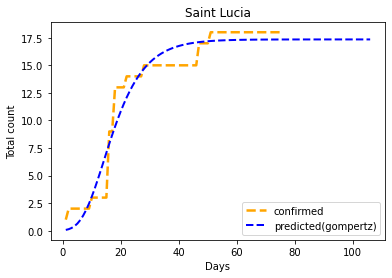

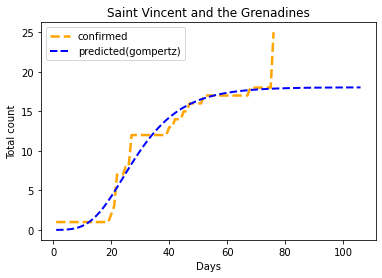

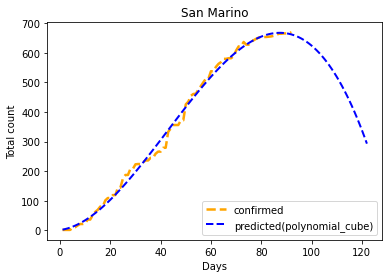

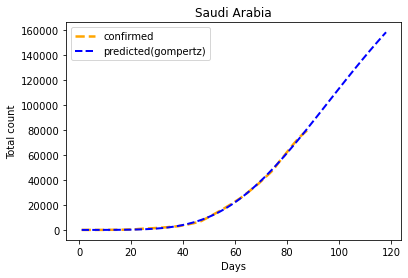

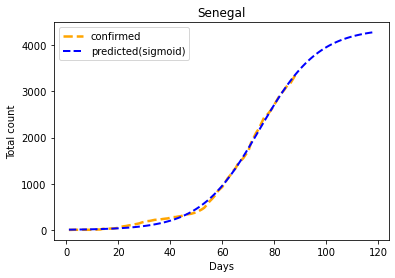

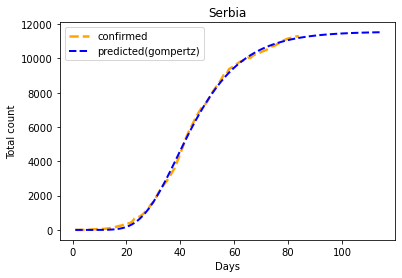

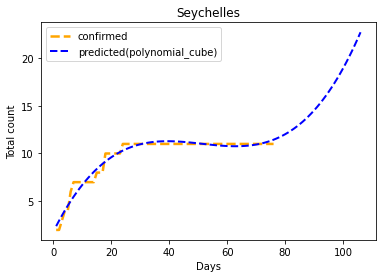

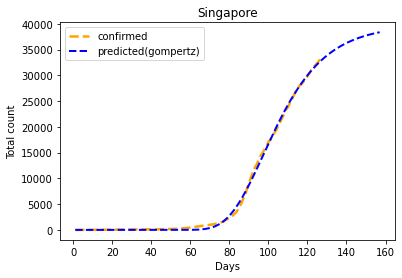

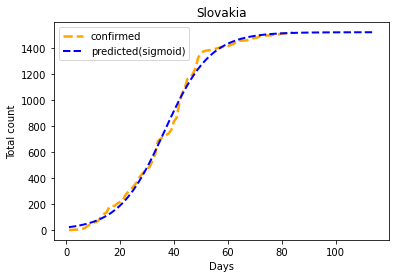

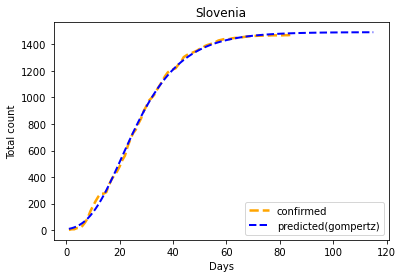

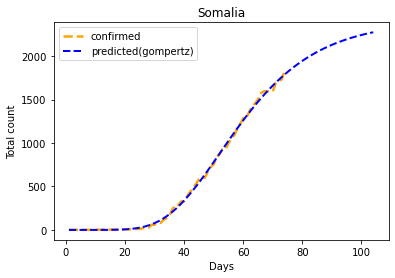

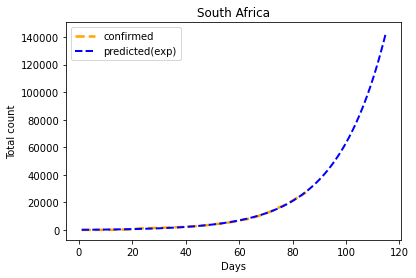

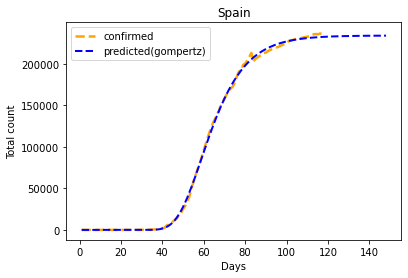

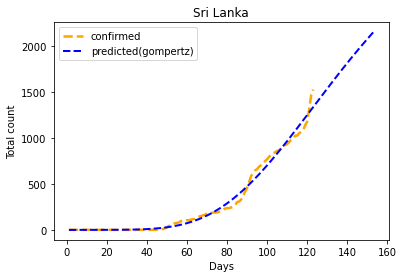

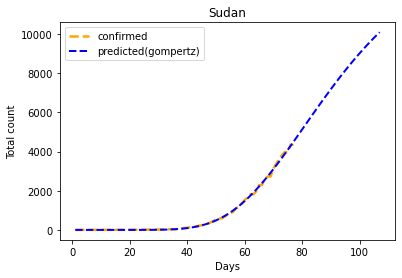

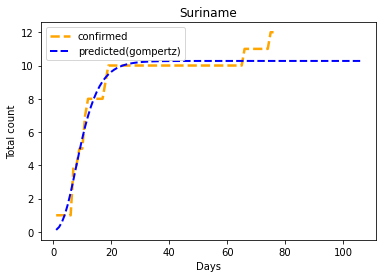

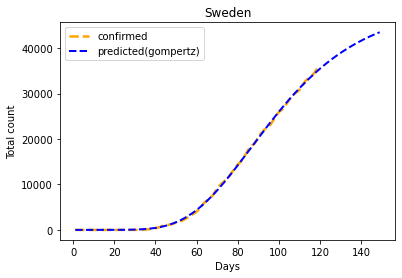

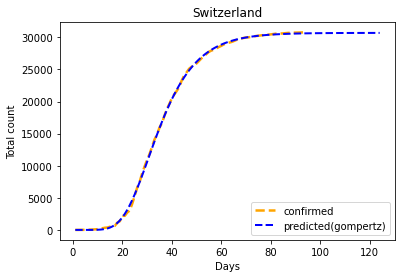

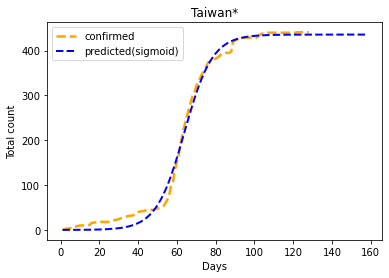

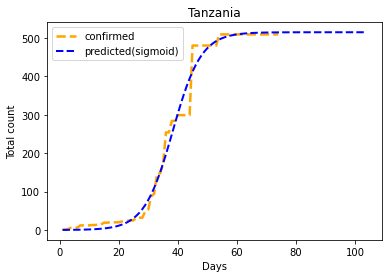

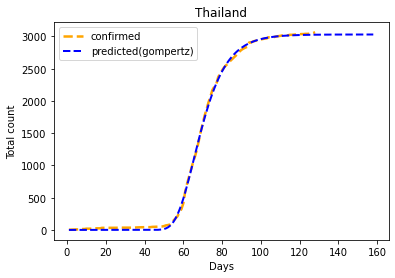

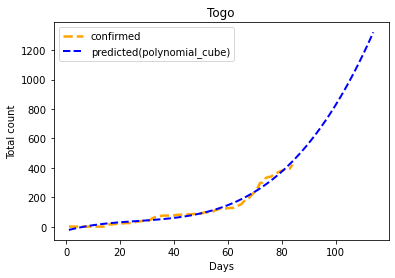

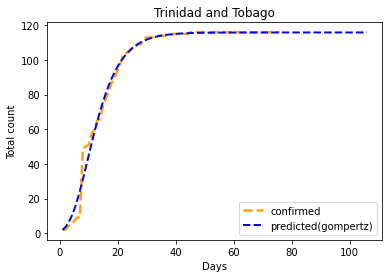

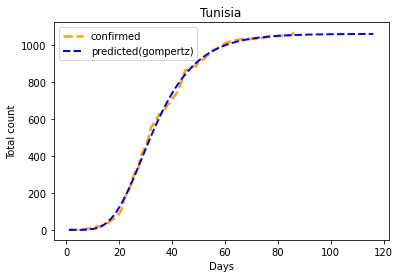

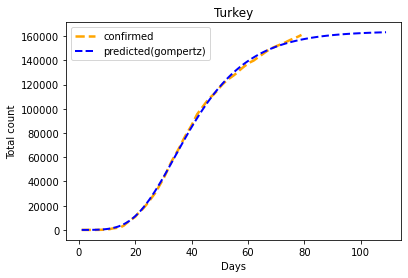

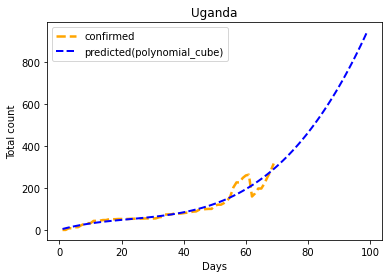

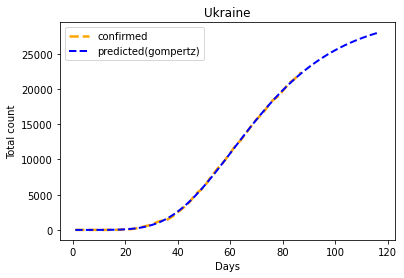

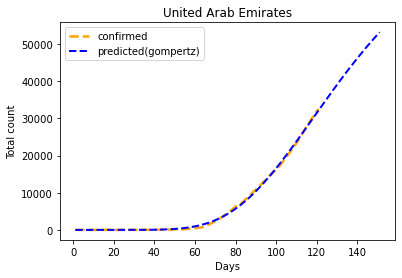

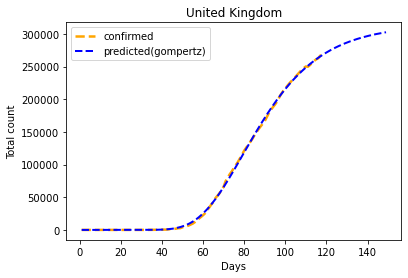

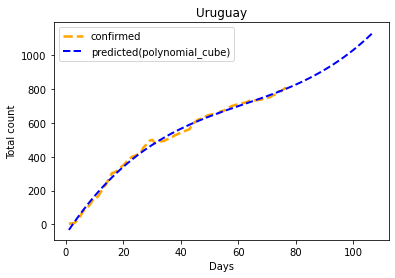

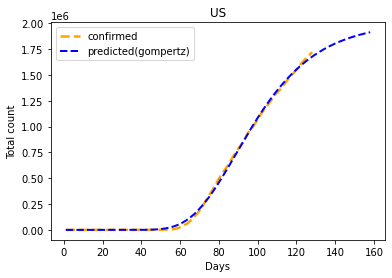

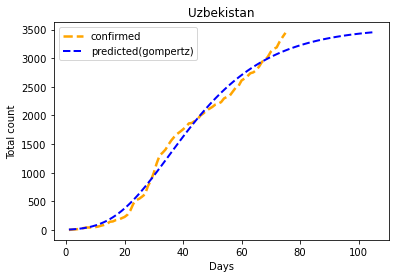

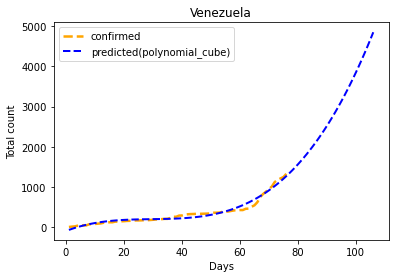

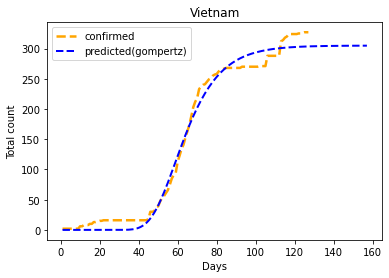

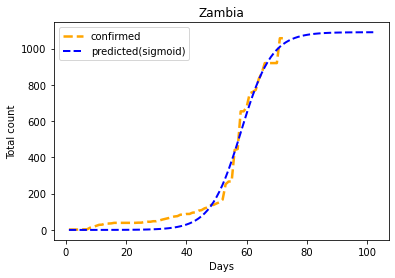

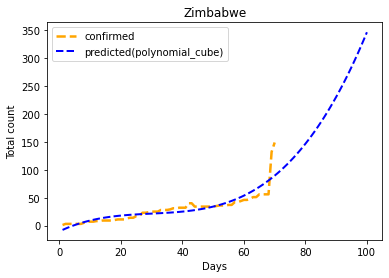

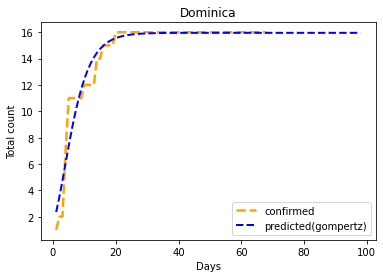

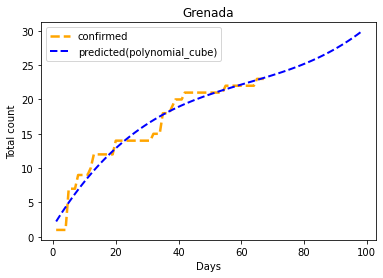

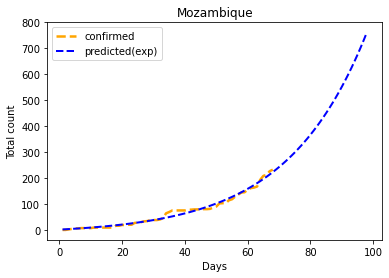

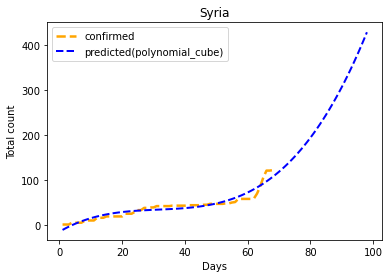

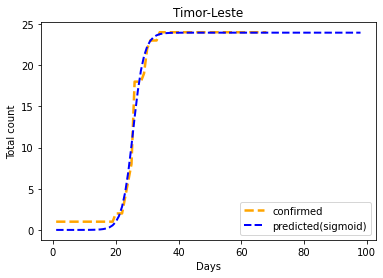

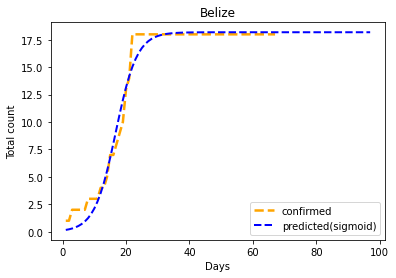

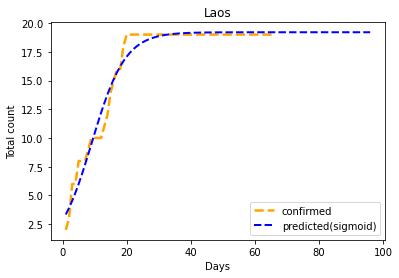

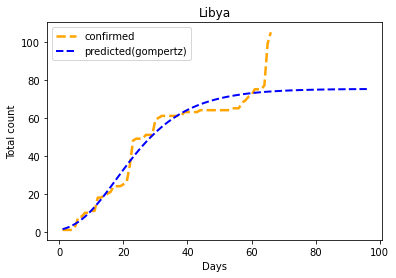

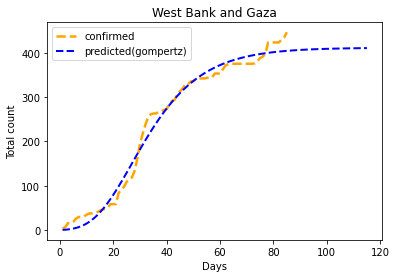

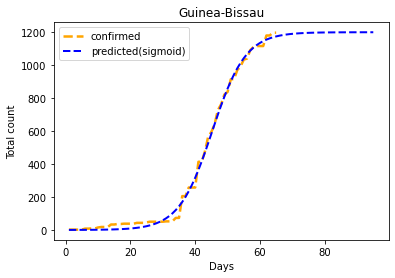

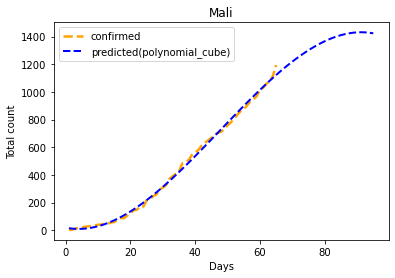

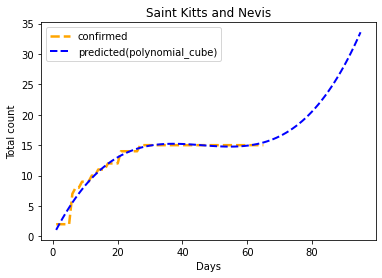

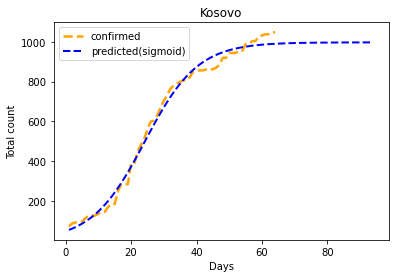

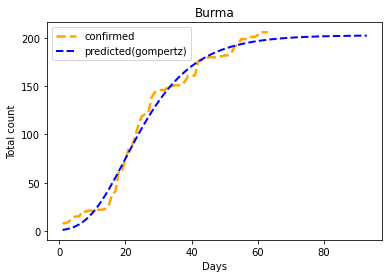

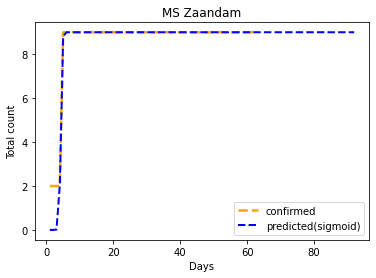

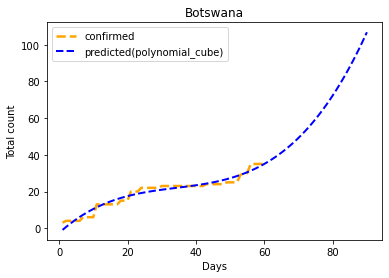

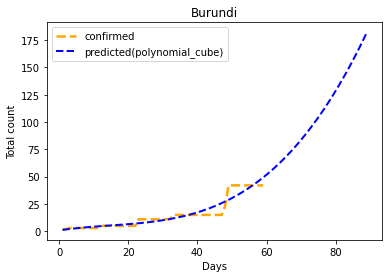

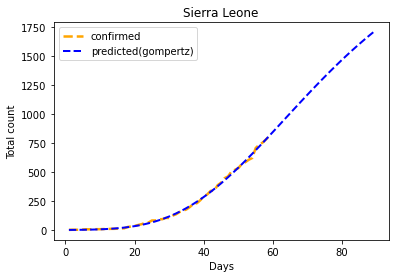

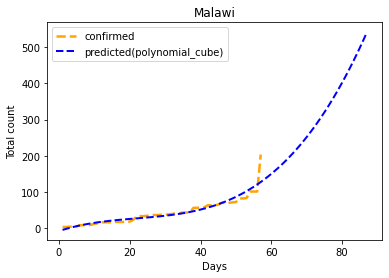

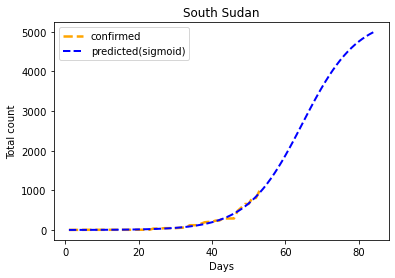

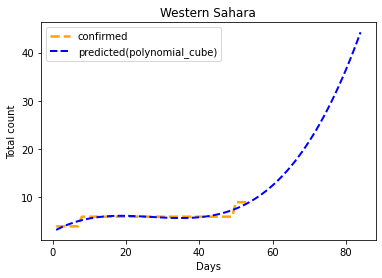

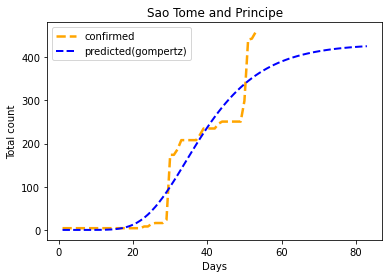

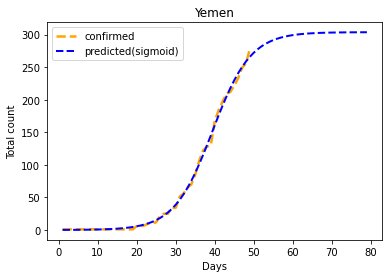

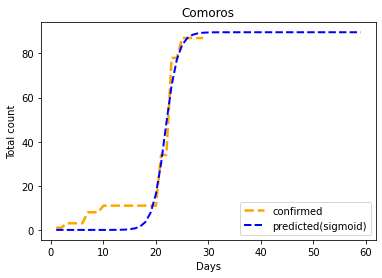

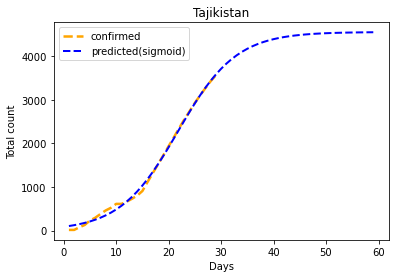

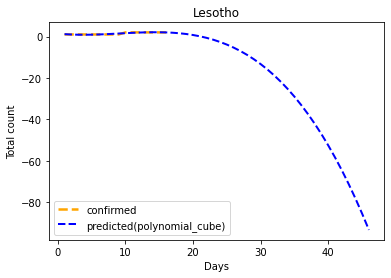

In [93]:
forecast_countries_auto(data, status = 'confirmed',functions = functions_to_fit, period = 30)

In [12]:
def forecast_world(data, status = 'confirmed', model_function = "sigmoid", period = 30):
    days = range(len(data[list(data.keys())[0]]))
    x = np.array(days) + 1
    y = []
    for day in days:
        total = 0
        for name in data.keys():
            total += int(data[name][day][status])
        y.append(total)
    y = np.array(y)
    colors = {'confirmed':'orange' , 'deaths':'r', 'recovered':'g'}
    #как выбирать p0? # Здесь для сигмоиды
    #p0=[max(y), np.median(X), .1] - gompertz
    #p0=[max(y), 1, np.median(x)] - sigmoid
    if model_function == "sigmoid":
        p = [max(y), 1, np.median(x)]
    if model_function == "gompertz":
        p = [max(y), np.median(x), .1]
    else:
        p = [1,0,1] #?
    opt_params , pcov = curve_fit(model_functions[model_function],x,y , p0=p,maxfev = 30000)
    x_modeled = np.array([x + 1 for x in range(len(x) + period)])
    estimated = model_functions[model_function](x_modeled,*opt_params)
    estimated_color = "blue" 
    plt.plot(x,y,"--",color=colors[status], linewidth=2.5, label=status)
    plt.plot(x_modeled,estimated,"--",color=estimated_color, linewidth=2.0, label="predicted")
    plt.title("Global")
    plt.xlabel("Days")
    plt.ylabel("Total count")
    plt.legend()
    plt.show()

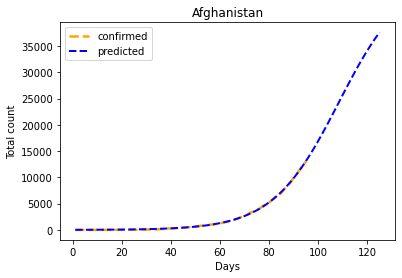

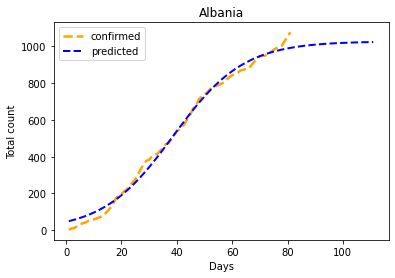

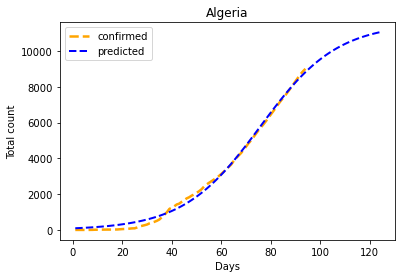

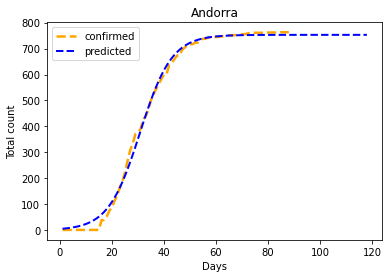

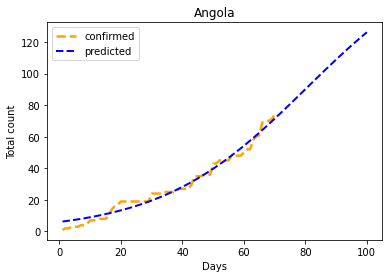

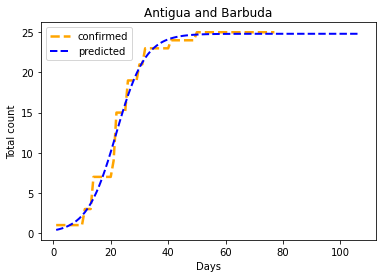

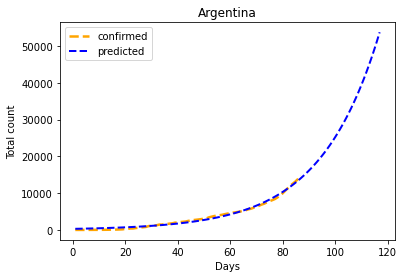

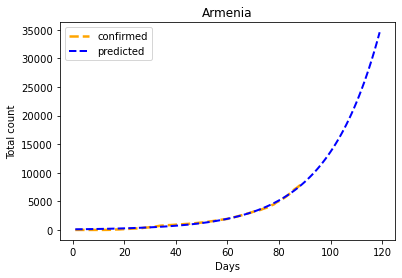

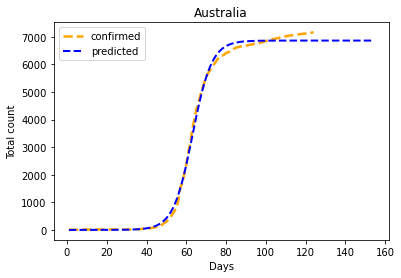

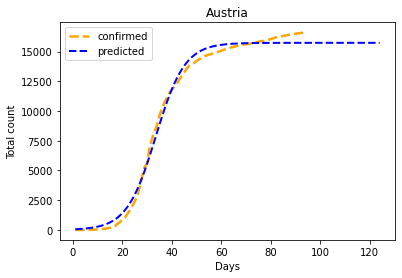

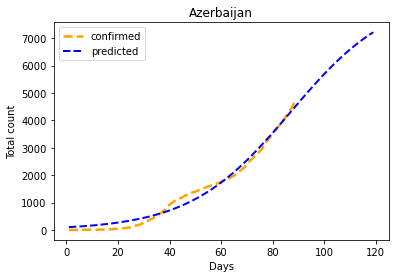

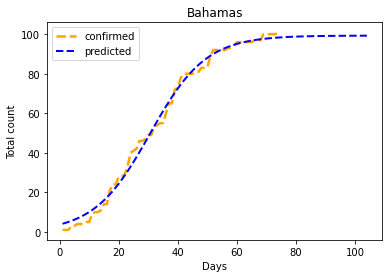

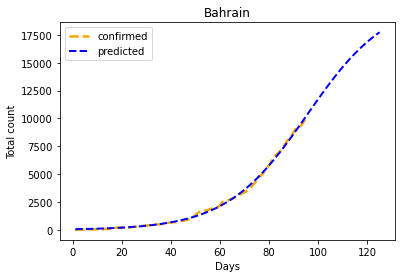

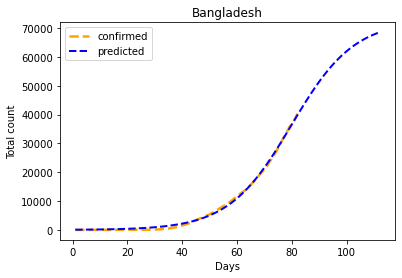

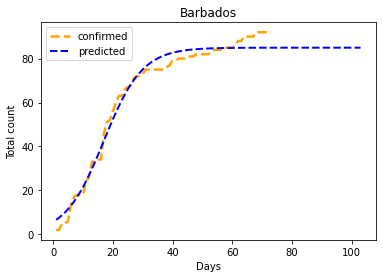

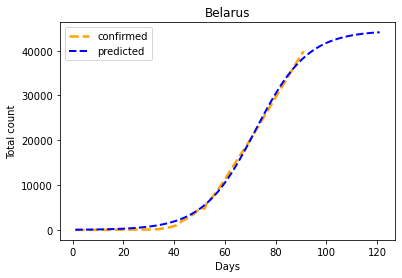

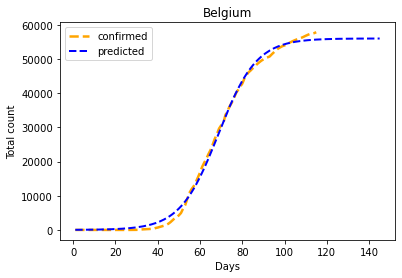

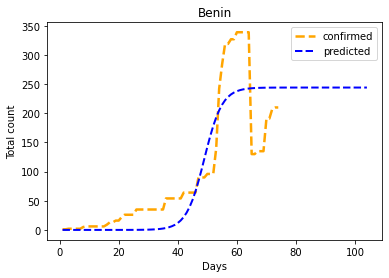

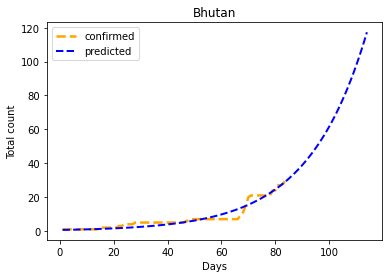

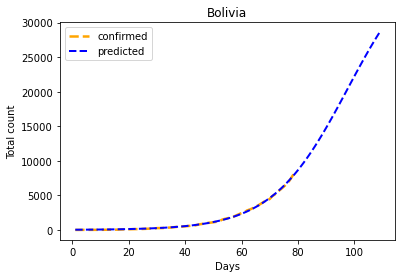

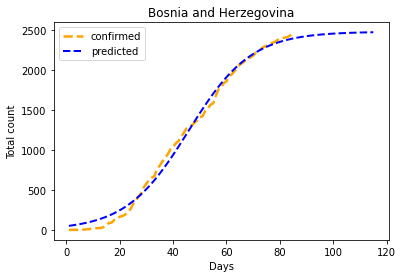

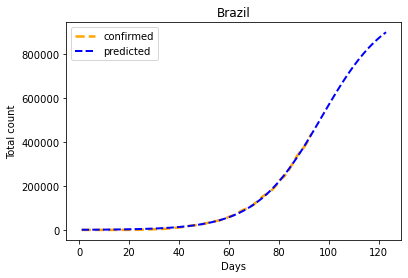

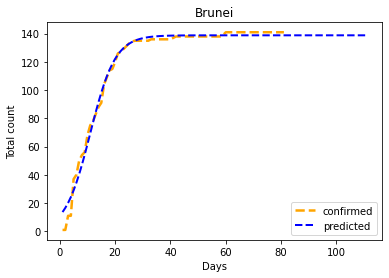

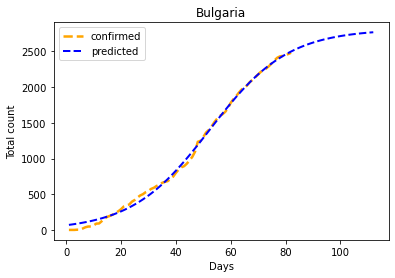

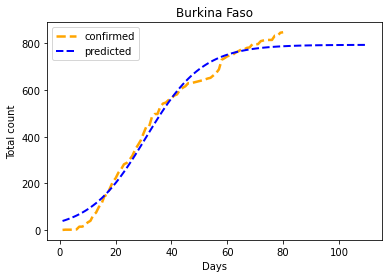

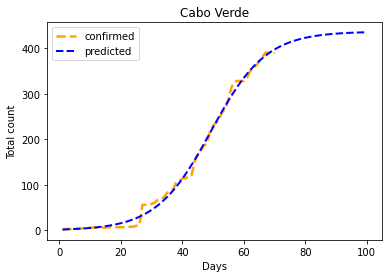

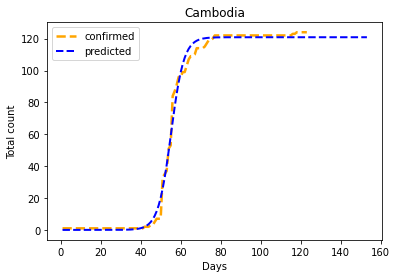

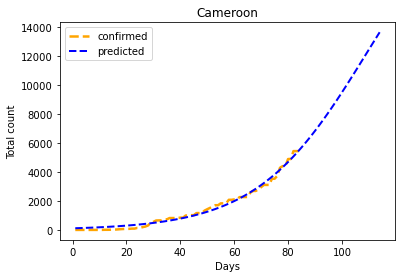

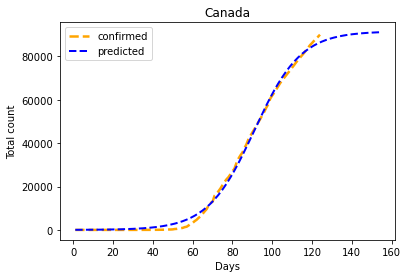

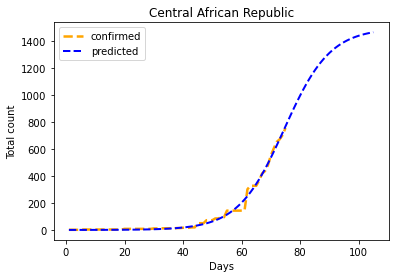

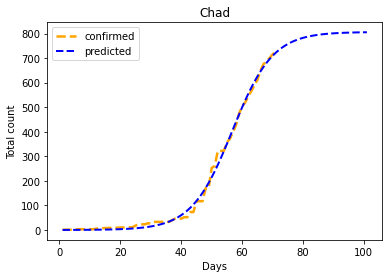

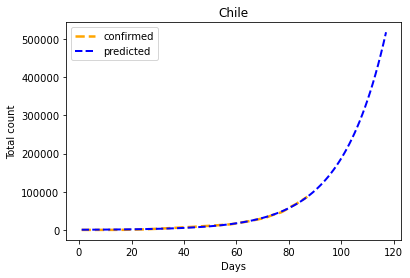

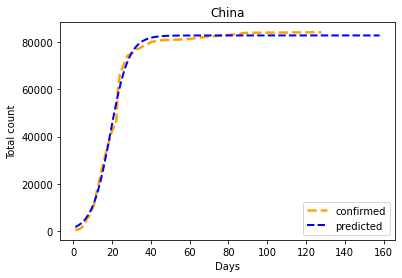

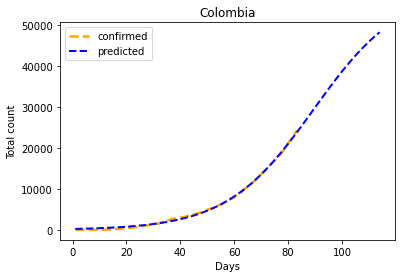

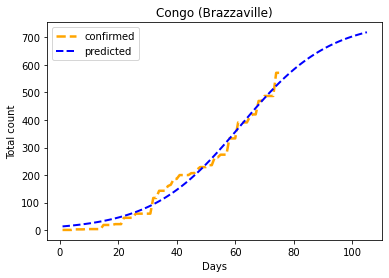

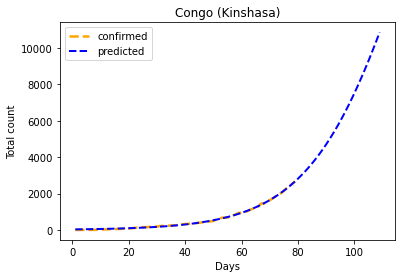

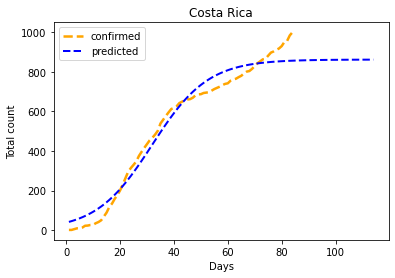

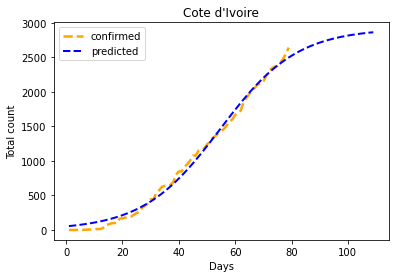

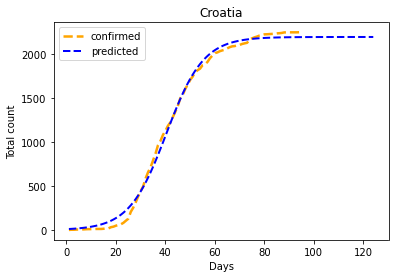

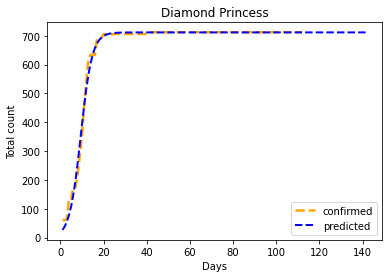

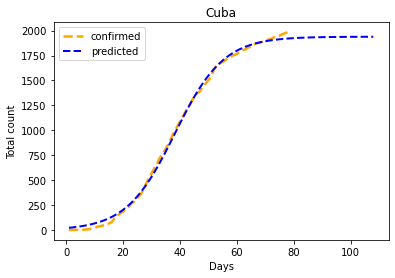

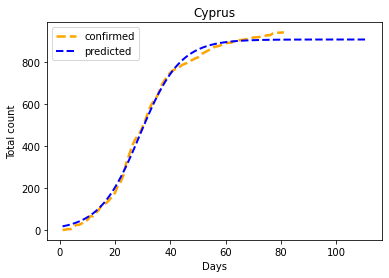

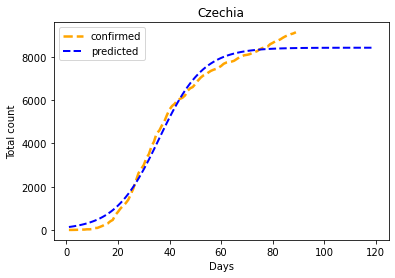

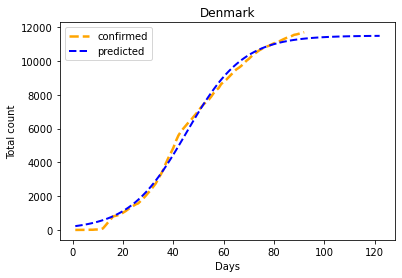

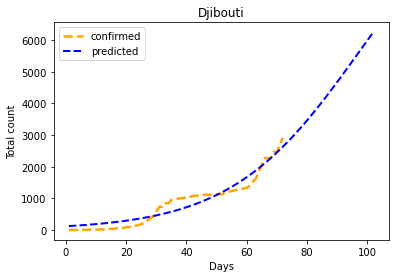

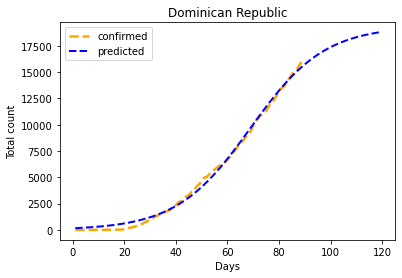

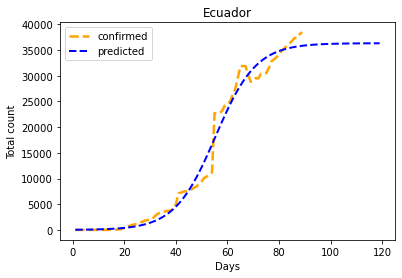

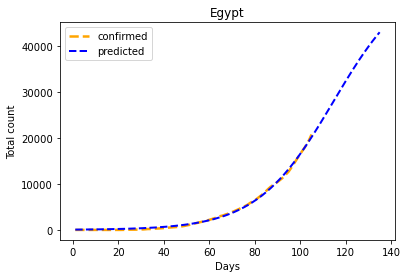

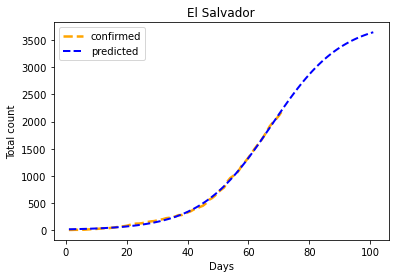

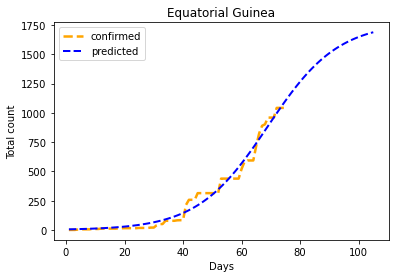

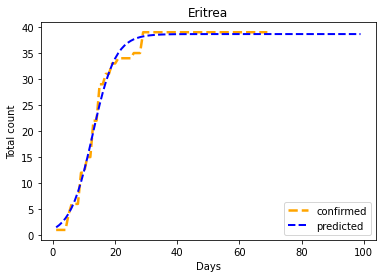

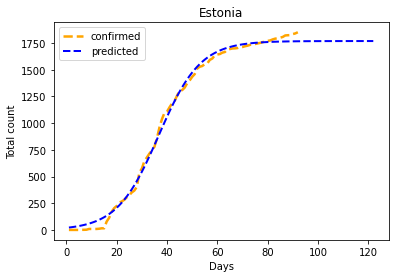

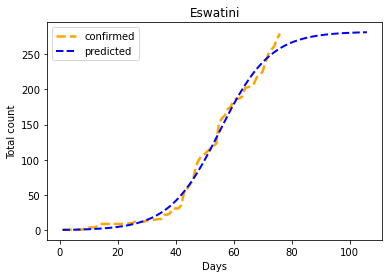

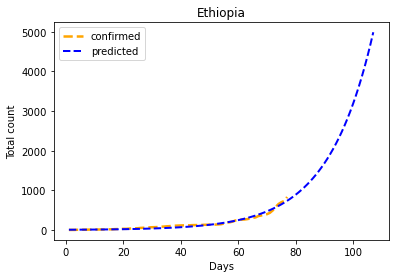

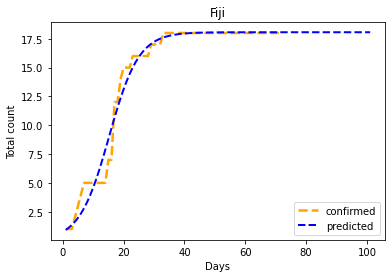

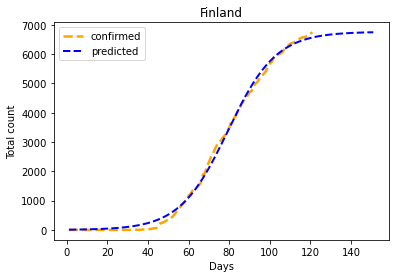

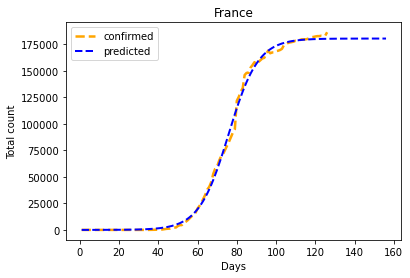

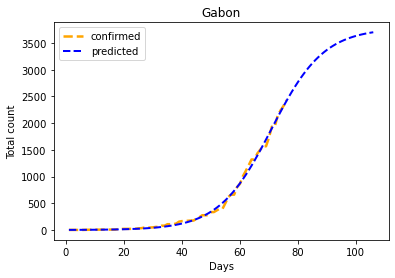

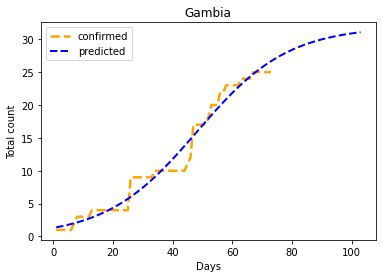

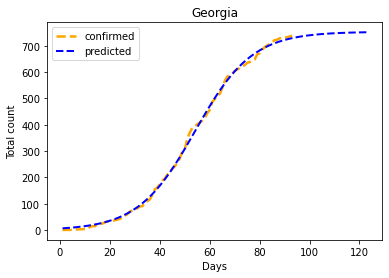

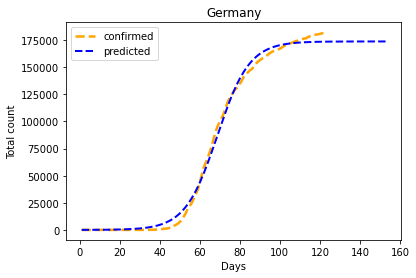

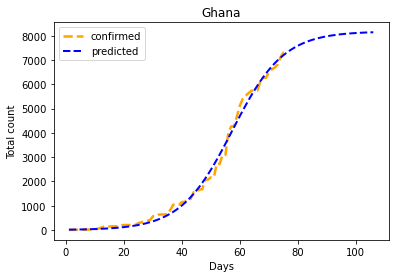

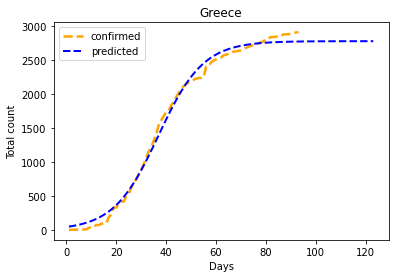

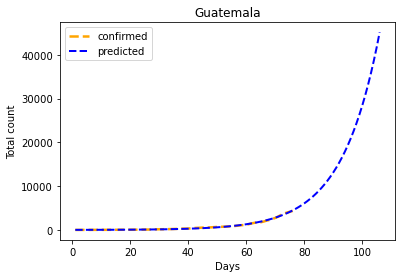

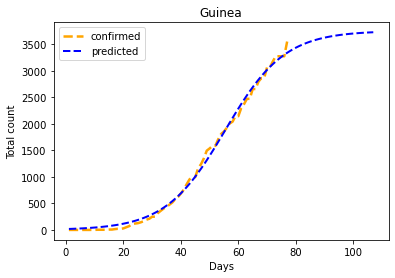

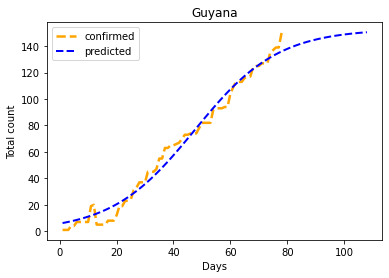

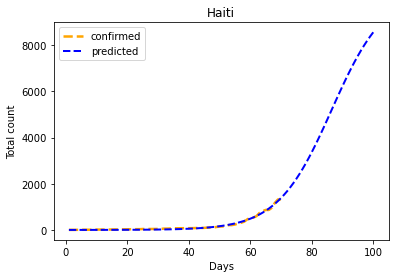

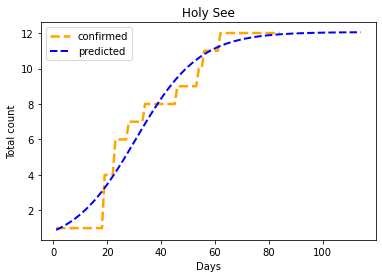

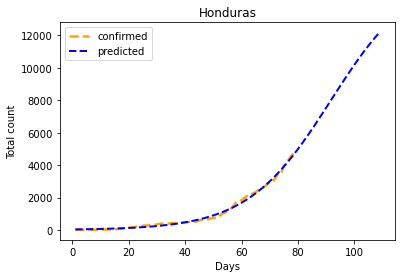

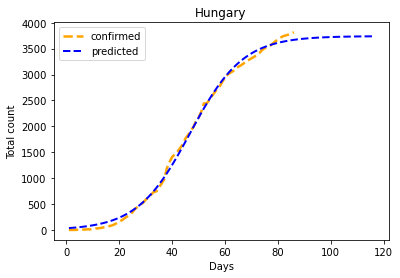

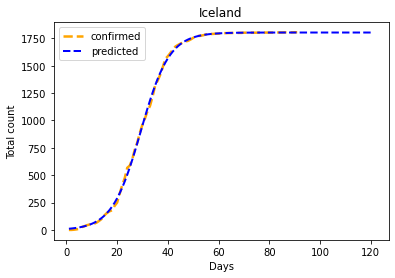

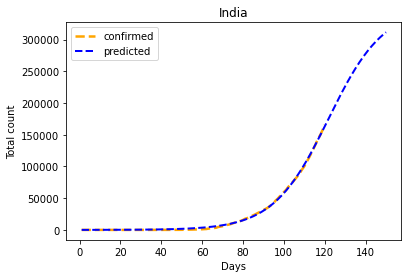

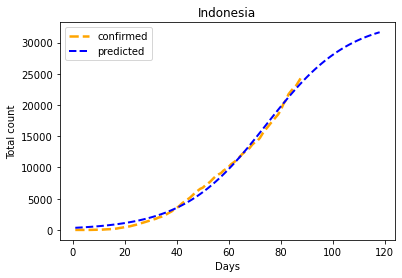

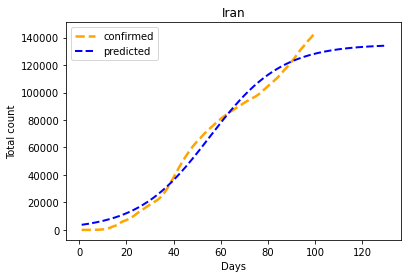

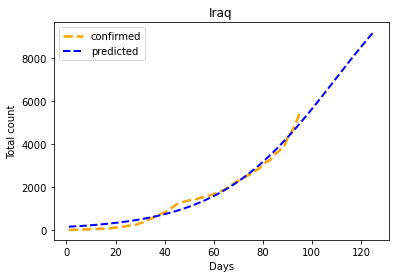

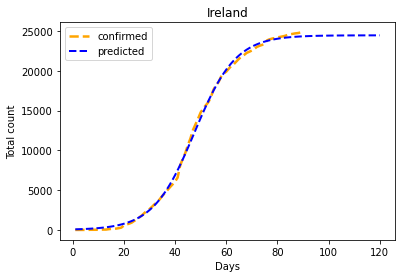

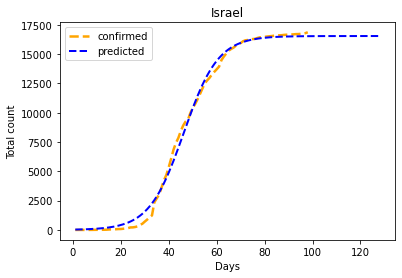

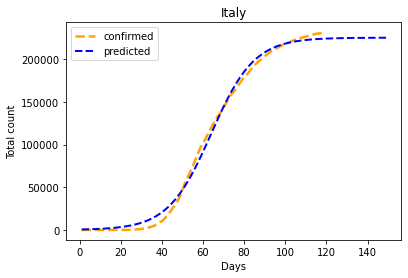

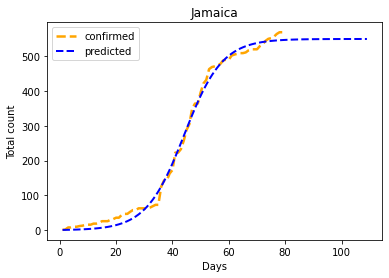

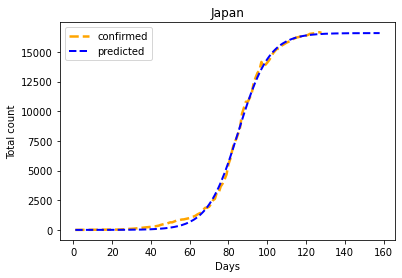

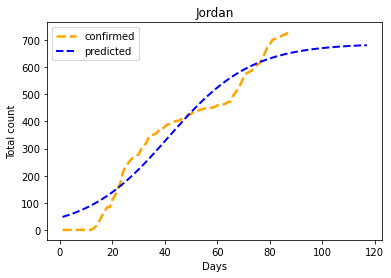

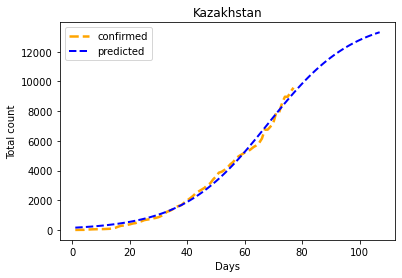

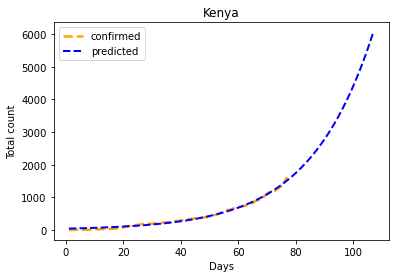

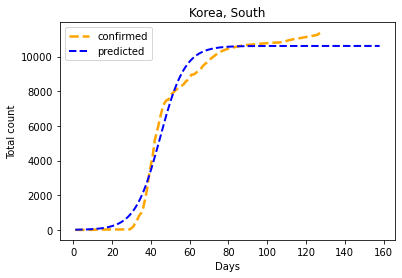

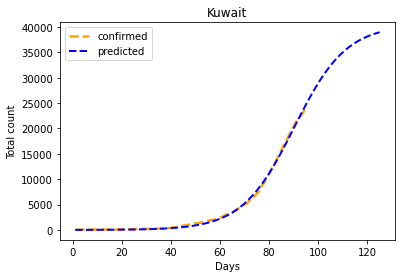

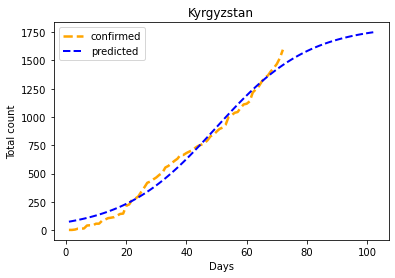

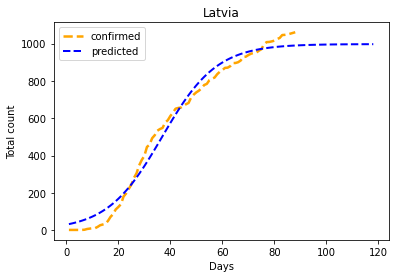

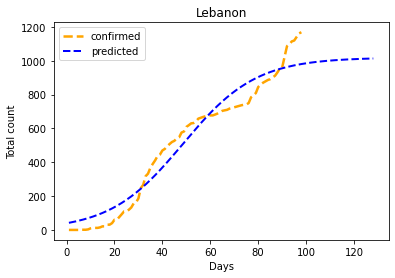

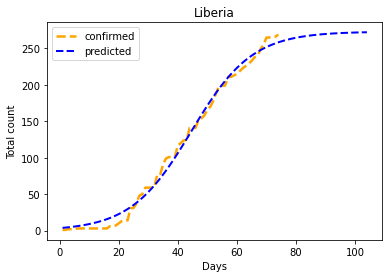

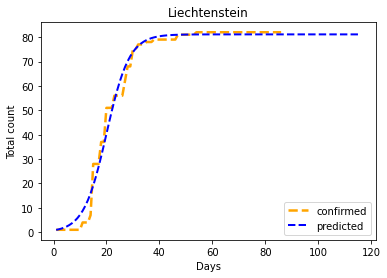

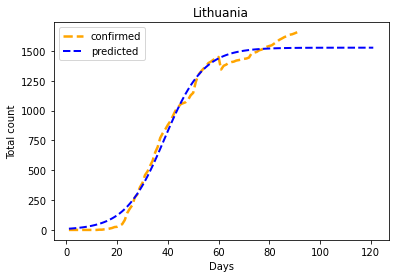

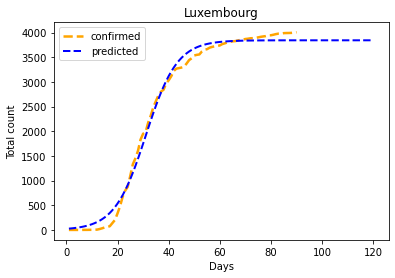

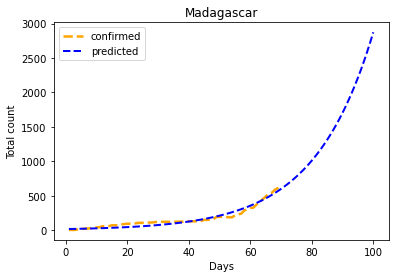

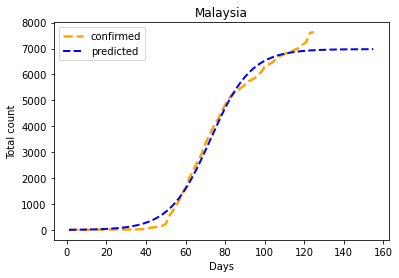

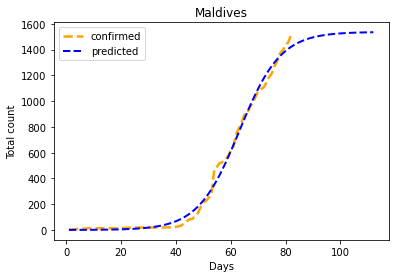

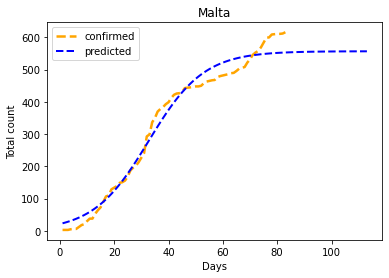

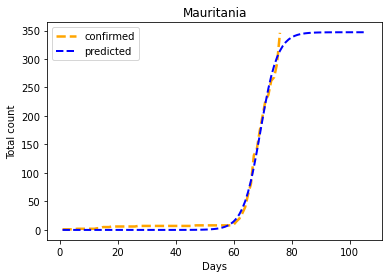

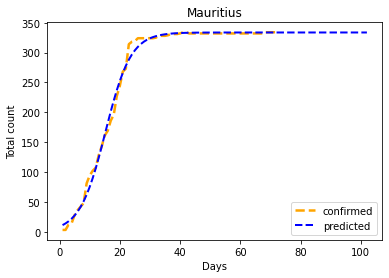

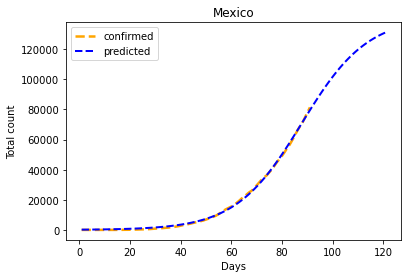

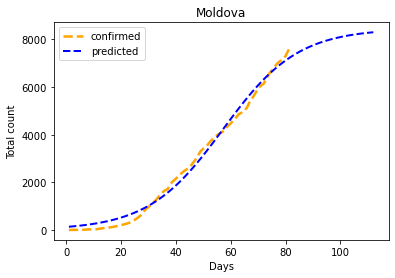

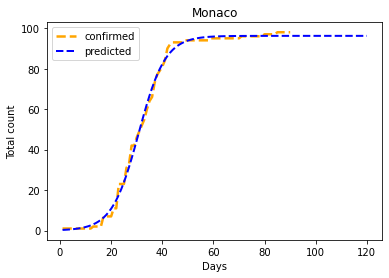

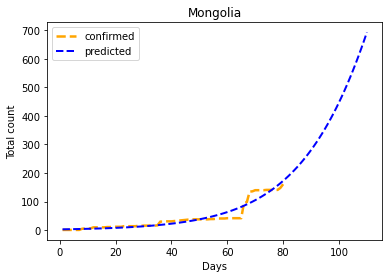

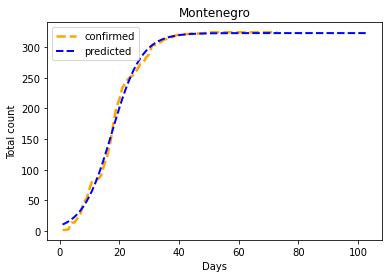

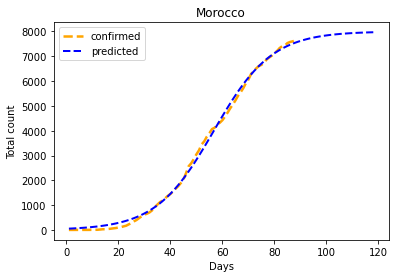

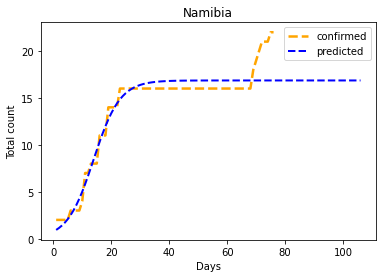

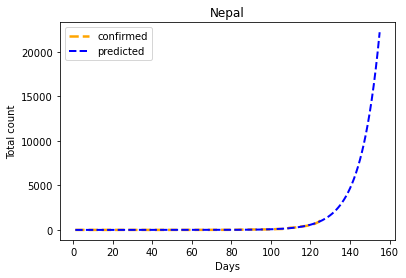

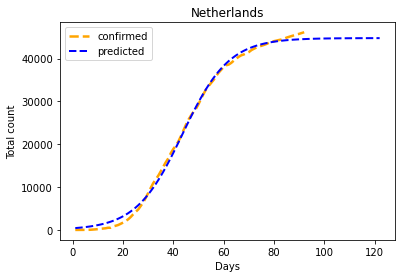

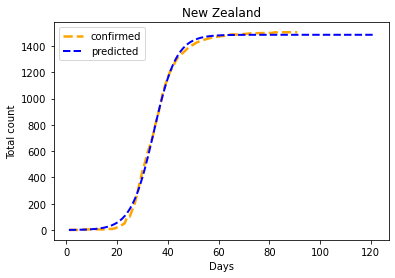

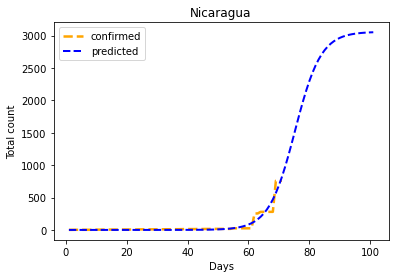

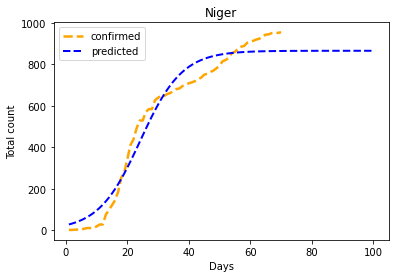

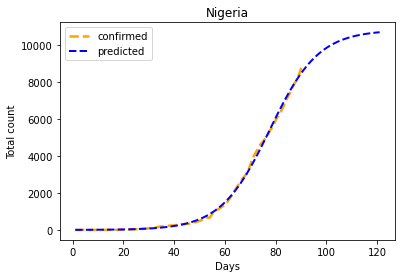

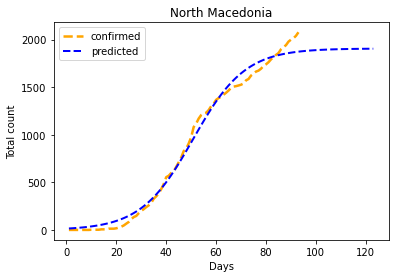

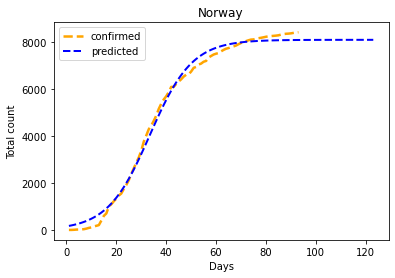

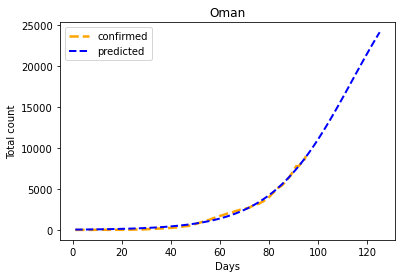

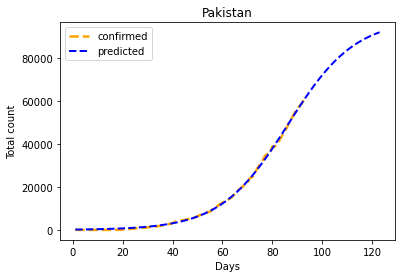

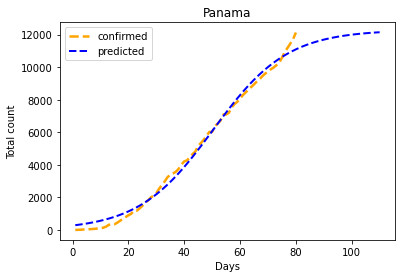

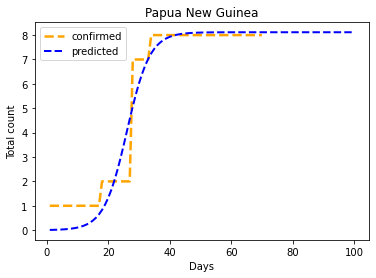

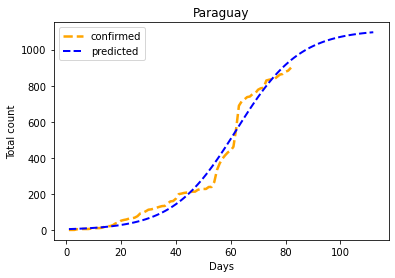

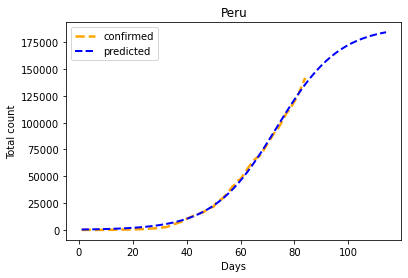

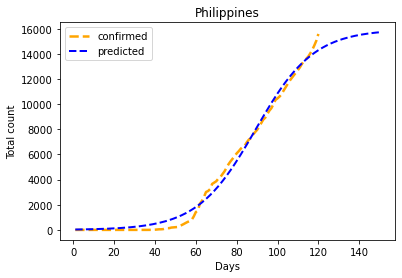

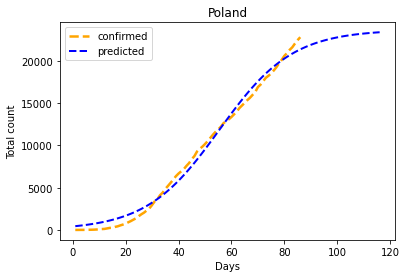

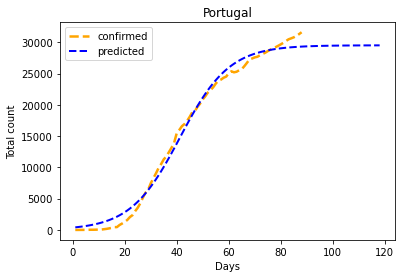

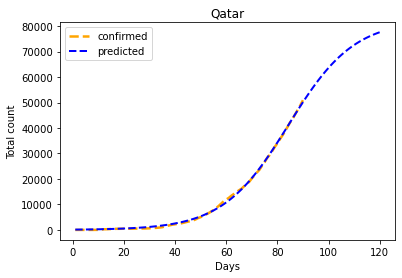

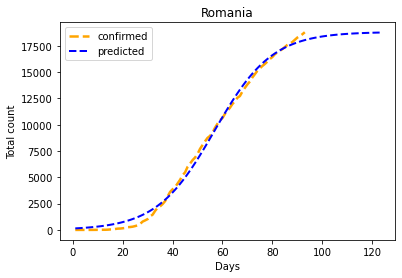

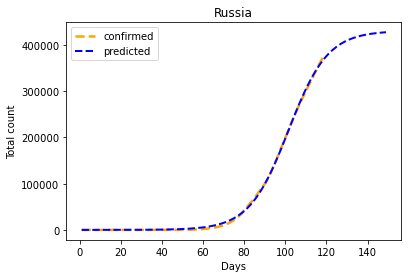

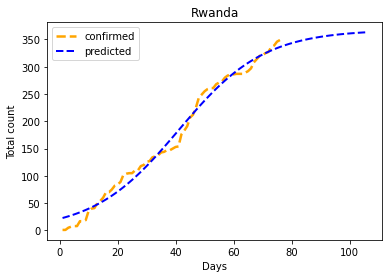

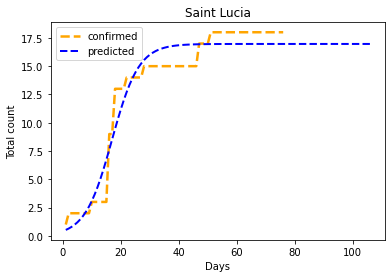

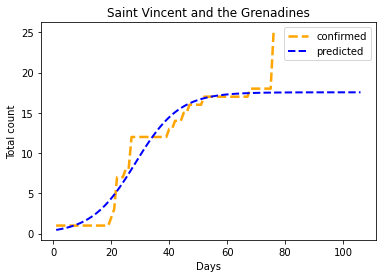

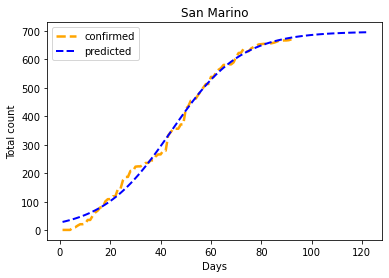

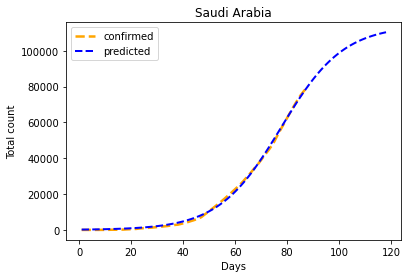

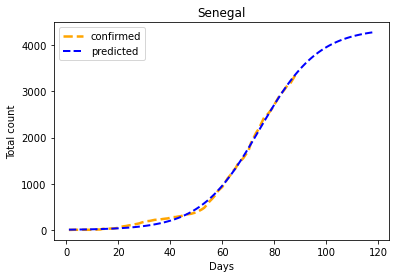

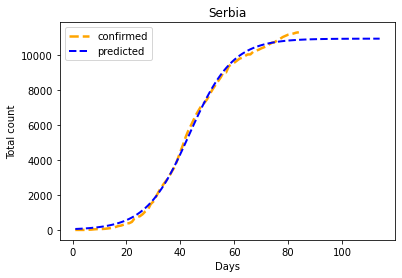

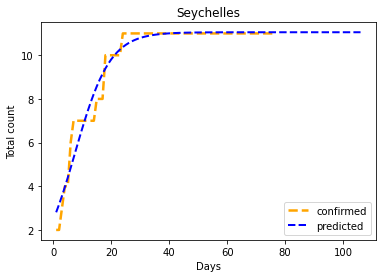

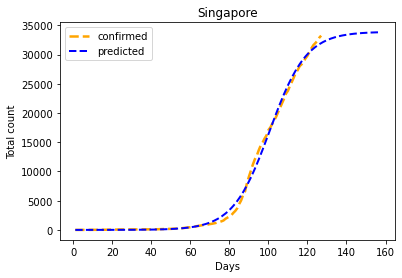

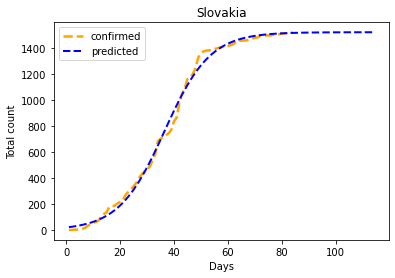

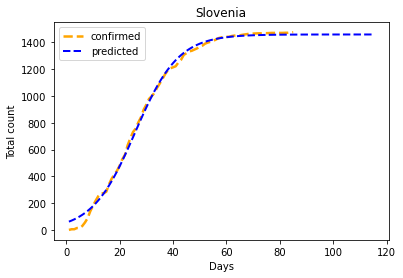

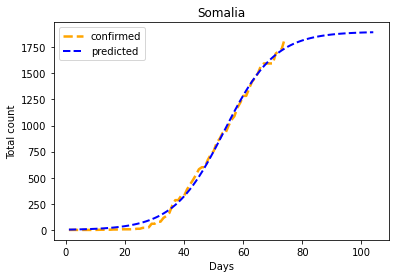

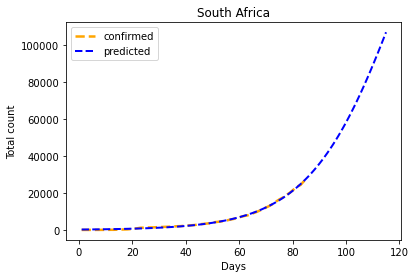

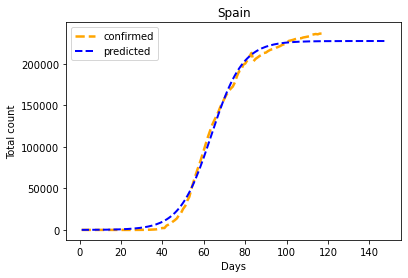

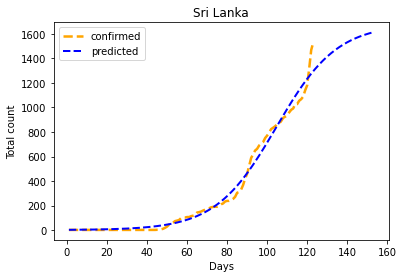

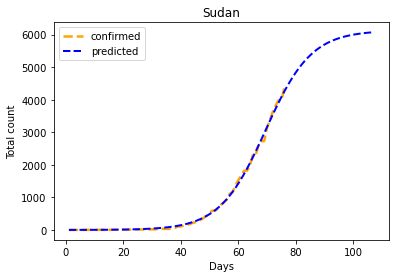

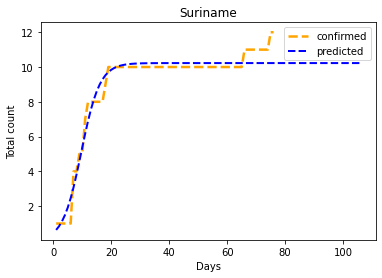

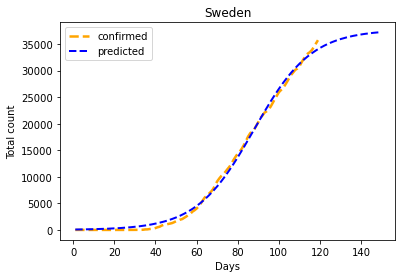

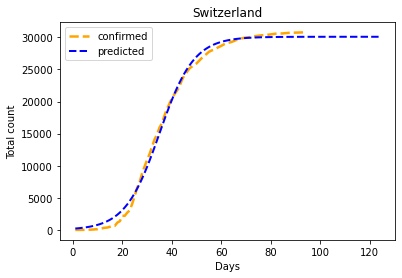

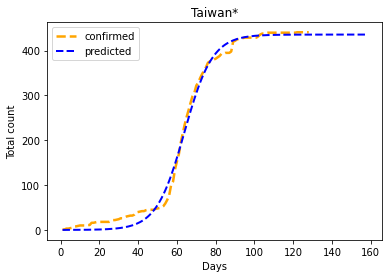

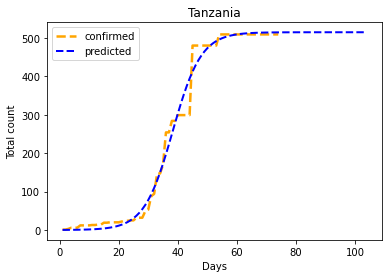

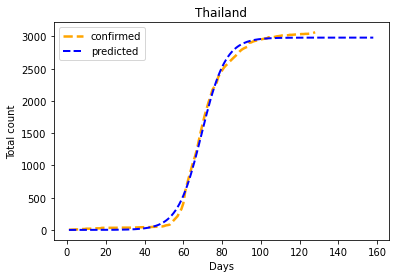

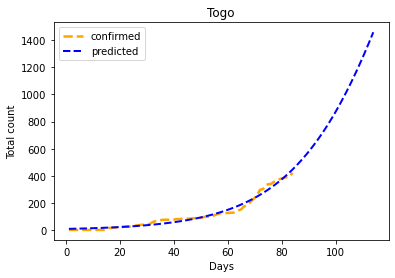

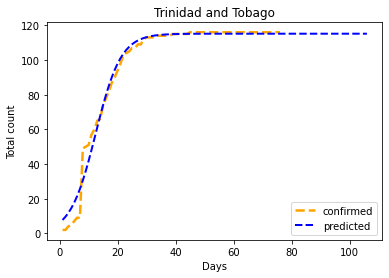

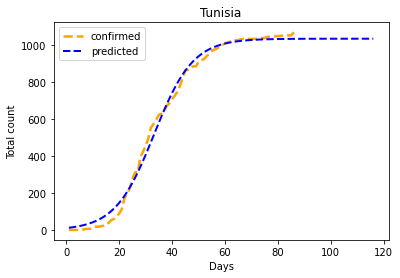

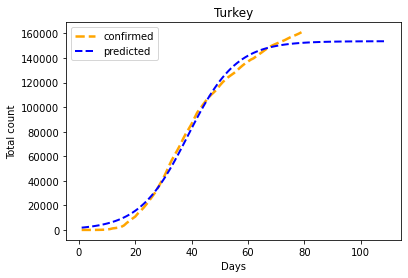

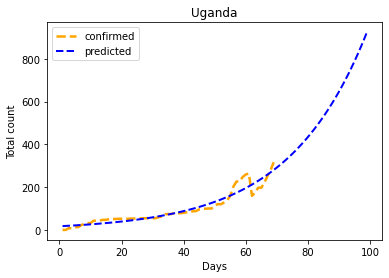

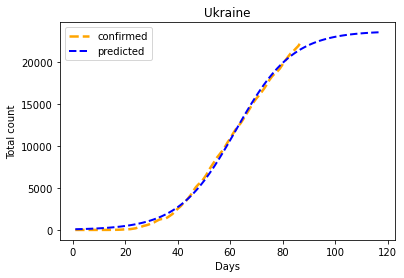

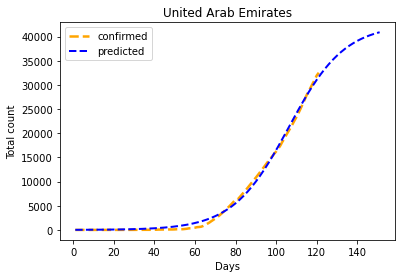

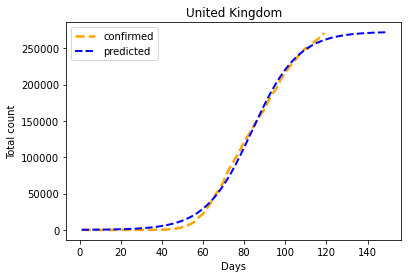

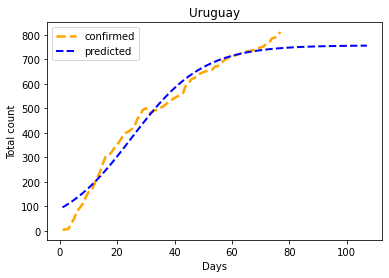

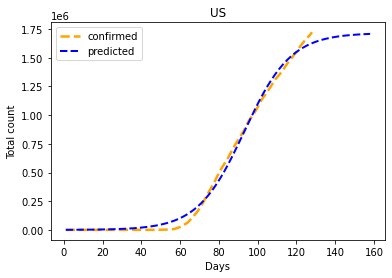

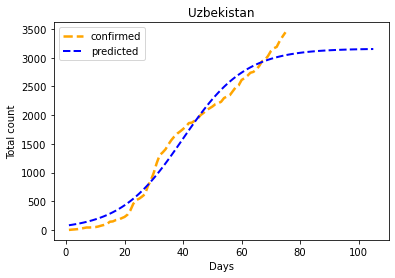

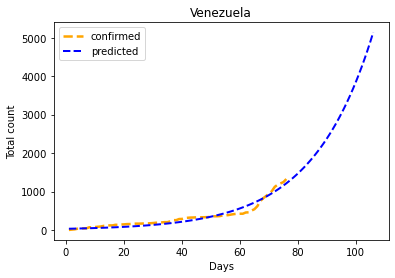

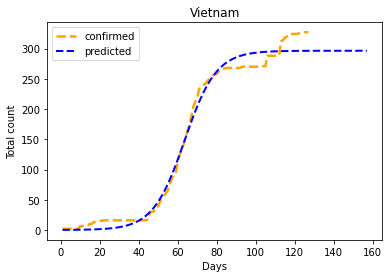

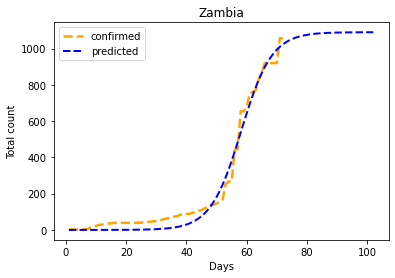

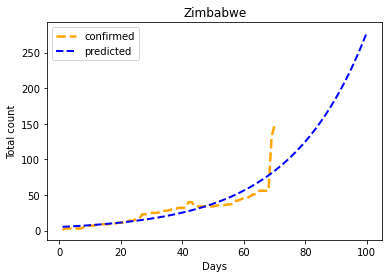

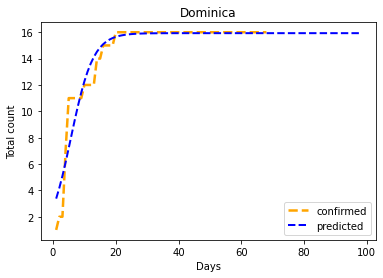

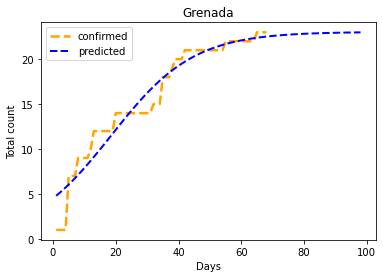

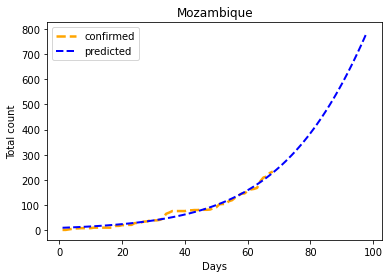

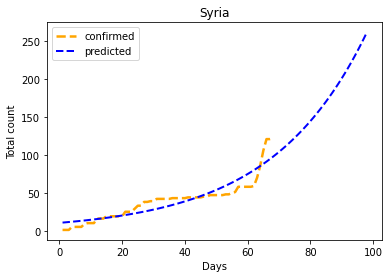

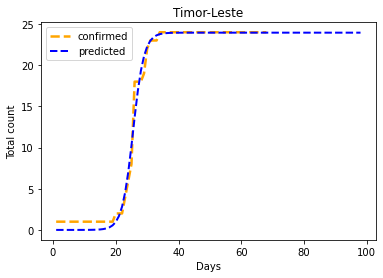

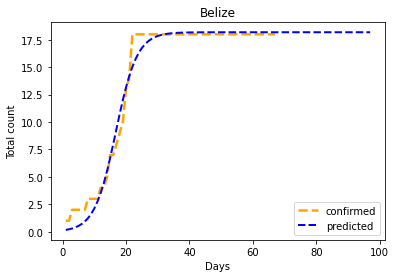

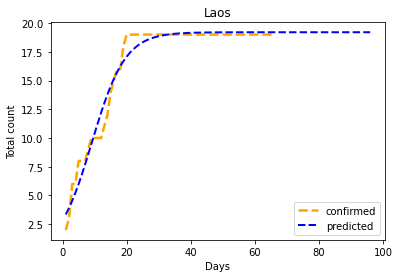

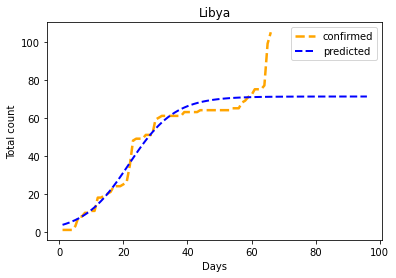

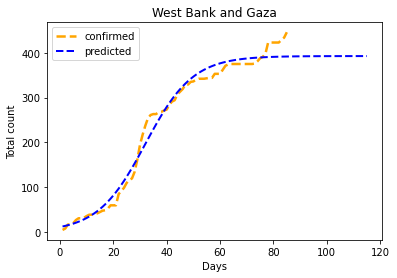

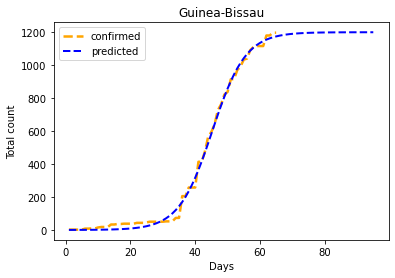

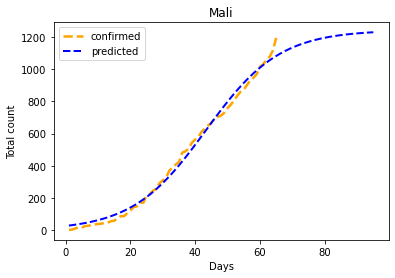

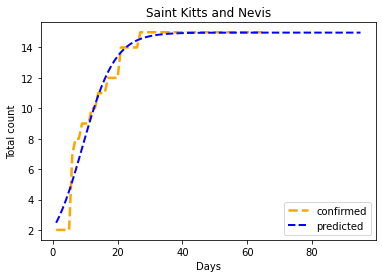

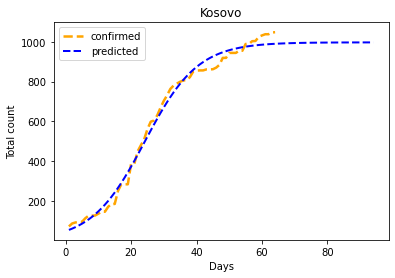

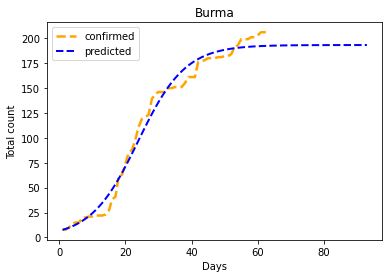

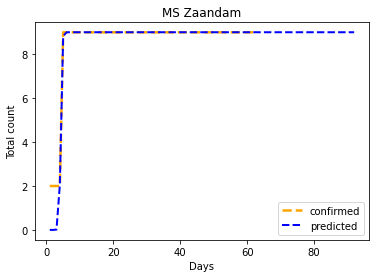

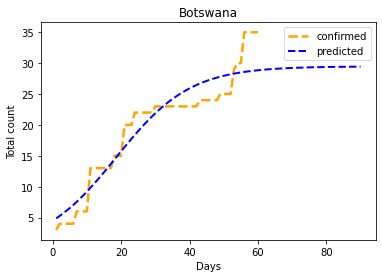

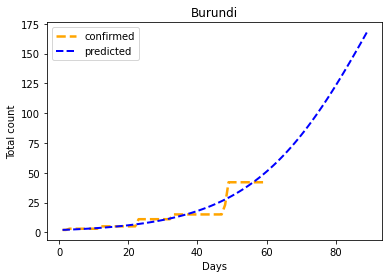

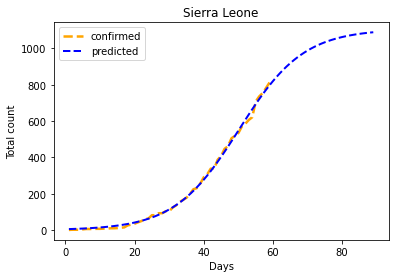

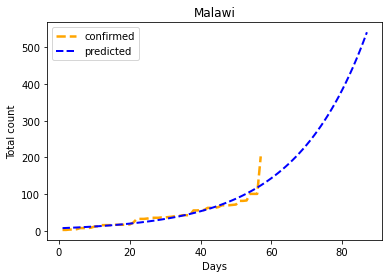

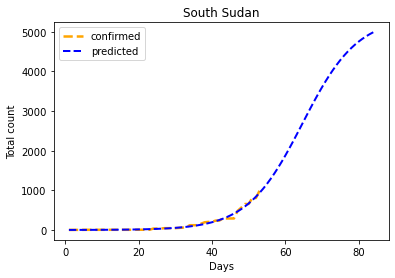

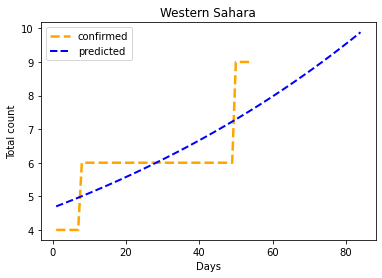

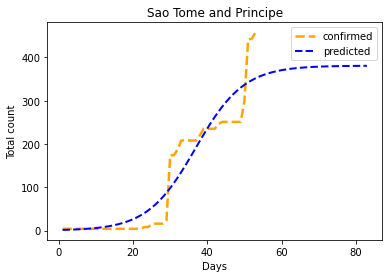

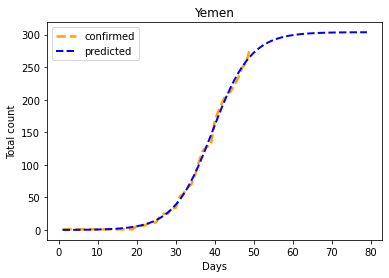

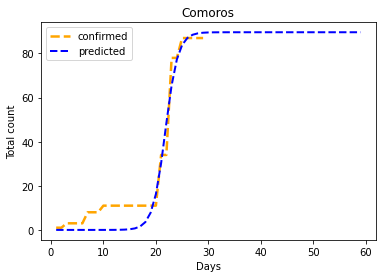

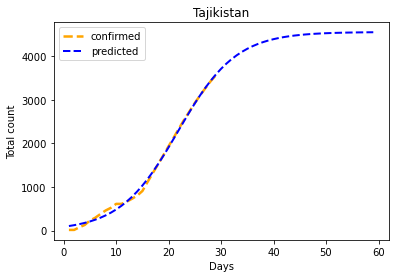

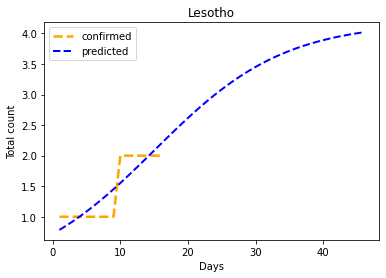

In [94]:
forecast_countries(data, status = 'confirmed', model_function = "sigmoid", period = 30)

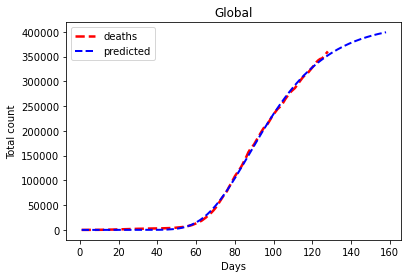

In [79]:
forecast_world(data,status = 'deaths', model_function = "gompertz")

In [ ]:
# кластеризация через процент заболевших, умерших, ВВП и среднедушевой доход

In [17]:
data = requests.get(SOURCE_COVID_19).json()
pop_data = requests.get(SOURCE_COUNTRIES_BY_POPULATION).json()

In [18]:
gdp_data_response = requests.get(SOURCE_GDP)
gdp_csv_path = "gdp.csv"
set_csv_file(gdp_data_response,gdp_csv_path)

In [19]:
per_capita_data = requests.get(SOURCE_GDP_PER_CAPITA_JSON).json()

In [20]:
def percentage(data, pop_data):
    for c in pop_data:
        c['country'] = change(c['country'])
    countries = []
    for name in data.keys():
        for c in pop_data:
            if change(name) == c['country']:
                population = int(c['population'])
                conf_to_pop = (int(data[name][len(data[name])-1]['confirmed']) / population) * 100
                dead_to_pop = (data[name][len(data[name])-1]['deaths'] / population) * 100
                countries.append({'country':change(name) , 'population':population , 'conf_to_pop':conf_to_pop, 'dead_to_pop':dead_to_pop})
                break
    return countries

In [21]:
def gdp(csv_path):
    countries = []
    length = 0
    with open(csv_path,"r") as csv_file:
        for line in csv_file:
            length +=1
    count = 0
    with open(csv_path,"r") as csv_file:
        line = csv_file.readline().split(",")
        while (line[0] != "Afghanistan"):
            line = csv_file.readline().split(",")
        while(count< length):
            line = csv_file.readline().split(",")
            if len(line) < 4:
                break
            #if line[2] == "2016": # было
            if line[-2] == "2016":
                #countries.append({"country":change((line[0])) , "gdp":int(float(line[3]))}) # было
                countries.append({"country":change((line[0].split("\"")[-1])) , "gdp":int(float(line[-1]))})
                
            count+=1
    return countries

In [22]:
def per_capita(per_capita_data):
    countries = []
    length = len(per_capita_data)
    count = 0
    _iter = iter(per_capita_data)
    key = next(_iter)

    while key['Country Name']!= 'Afghanistan':
        key = next(_iter)
        count+=1
    while(count + 1 < length):
        key = next(_iter)
        count+=1
        if(int(key['Year']) == 2016):
            countries.append({"country":change((key['Country Name'])) , "per_capita":int(key['Value'])})
    return countries

In [23]:
def unite(percentaged_list,gdp_list, per_capita_list):
    countries = []
    for p in percentaged_list:
        is_present = False
        for g in gdp_list:
            if p['country'] == g['country']:
                p['gdp'] = g['gdp']
                present = True
                break
        for c in per_capita_list:
            if p['country'] == c['country']:
                p['per_capita'] = c['per_capita']
                if present:
                    countries.append(p)
                break
    return countries

In [24]:
percentaged = percentage(data,pop_data)

In [25]:
_gdp = gdp(gdp_csv_path)

In [26]:
_per_capita = per_capita(per_capita_data)

In [27]:
countries = unite(percentaged, _gdp, _per_capita)


In [ ]:
df = pd.DataFrame(countries)[['country','population','gdp','per_capita','conf_to_pop','dead_to_pop']]
df.describe()

In [ ]:
df.dtypes

In [104]:
to_clust = df[['population','gdp','per_capita','conf_to_pop','dead_to_pop']]

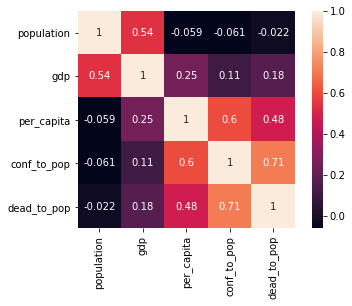

In [105]:
corr = to_clust.corr()
sns.heatmap(corr,square = True, annot = True)

In [ ]:
scaler = StandardScaler()
scaler.fit_transform(to_clust)

In [ ]:
data = dict(type = 'choropleth', 
           locations = df['country'],
           locationmode = 'country names',
           z = df['gdp'], 
           text = df['country'],
           colorbar = {'title':'ВВП'})
layout = dict(title = 'ВВП в долларах США', 
             geo = dict(showframe = False, 
                       projection = {'type': 'mercator'}))
choromap3 = go.Figure(data = [data], layout=layout)
iplot(choromap3)

In [ ]:
data = dict(type = 'choropleth', 
           locations = df['country'],
           locationmode = 'country names',
           z = df['per_capita'], 
           text = df['country'],
           colorbar = {'title':'Среднедушевой доход'})
layout = dict(title = 'Среднедушевой доход в долларах США', 
             geo = dict(showframe = False, 
                       projection = {'type': 'mercator'}))
choromap3 = go.Figure(data = [data], layout=layout)
iplot(choromap3)

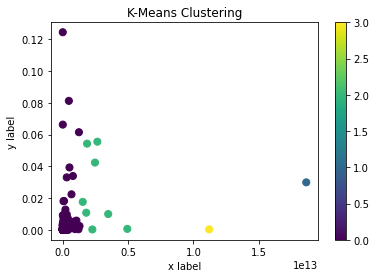

In [108]:
def doKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

clust_labels, cent = doKmeans(to_clust, 4)
kmeans = pd.DataFrame(clust_labels)
if 'kmeans' not in to_clust.columns:
    to_clust.insert((to_clust.shape[1]),'kmeans',kmeans)

#Plot the clusters obtained using k means
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(to_clust['gdp'],to_clust['dead_to_pop'],
                     c=kmeans[0],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('x label')
ax.set_ylabel('y label')
plt.colorbar(scatter)



In [110]:
if 'country' not in to_clust.columns:
    to_clust.insert(0,'country',df.iloc[:,0])
data = [dict(type='choropleth',
             locations = to_clust['country'],
             locationmode = 'country names',
             z = to_clust['kmeans'],
             text = to_clust['country'],
             colorbar = {'title':'Cluster Group'})]
layout = dict(title='Clustering of Countries based on K-Means',
              geo=dict(showframe = False,
                       projection = {'type':'mercator'}))
map1 = go.Figure(data = data, layout=layout)
iplot(map1)

In [ ]:
# import statements
from sklearn.datasets import make_blobs
data = make_blobs(n_samples=200, n_features=2, centers=4, cluster_std=1.6, random_state=50)# create np array for data points
points = data[0]# create scatter plot
for p in points[:5]:
    print(p)
plt.scatter(data[0][:,0], data[0][:,1], c=data[1], cmap='viridis')
plt.xlim(-15,15)
plt.ylim(-15,15)
# create kmeans object
kmeans = KMeans(n_clusters=4)# fit kmeans object to data
kmeans.fit(points)# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)# save new clusters for chart
y_km = kmeans.fit_predict(points)
plt.scatter(points[y_km ==0,0], points[y_km == 0,1], s=50, c='red')
plt.scatter(points[y_km ==1,0], points[y_km == 1,1], s=50, c='black')
plt.scatter(points[y_km ==2,0], points[y_km == 2,1], s=50, c='blue')
plt.scatter(points[y_km ==3,0], points[y_km == 3,1], s=50, c='cyan')